# TRABALHO 1 LabIACD

### Desenvolvido por:
        -Francisco Tavares
        -Guilherme Oliveira
        -Rodrigo Batista
        -Rodrigo Taveira

<a id="indice"></a>
## Índice

1. [Introdução](#introducao)

2. [Objetivo](#objetivo)

3. [Pré processamento 1](#pre-processamento-1)

4. [Criação do dataset com as anotações dos radiologistas](#criacao-do-noduledf)

5. [Isolar nodulos e criação de máscaras 2D](#isolar-nodulos-e-criacao-de-mascaras-2d)

6. [Visualização das máscaras 2D e extração de features](#visualizacao-das-mascaras-2d-e-extracao-de-features)

7. [Máscaras 3D](#mascaras-3d)

8. [Extração das features](#extracao-das-features)

9. [Pré Processamento 2](#pre-processamento-2)

10. [Feature Selection](#feature-selection)

11. [Modelos ML](#modelos-ml)

12. [Discussão dos resultados](#discussao-dos-resultados-1)

13. [Análise Estatística das Metricas](#analise-estatistica-das-metricas)

14. [Resultados obtidos para o 3D](#3d)

15. [Discussão dos resultados obtidos para o 3D](#discussao-resultados-3d)

16. [Comparação do 2D com o 3D](#comparacao-do-2d-com-o-3d)

17. [Conclusão](#conclusao)


<a id="introducao"></a>
## Introdução

[Go back to the top](#indice)

Este trabalho tem como objetivo explorar e documentar o processo de análise de imagens de tomografia computadorizada (CT) do tórax, focado na avaliação do risco de malignidade de nódulos pulmonares, a partir do uso do dataset público LIDC-IDRI. Utilizando bibliotecas amplamente reconhecidas como pylidc e Pyradiomics, o nosso objetivo é extrair e analisar características quantitativas das imagens.

Este projeto, desenvolvido no âmbito da disciplina de Laboratório de Inteligência Artificial e Ciência de Dados (Lab IA & DS), permitirá a aplicação de metodologias de ciência de dados e desenvolvimento de software adquiridas em disciplinas anteriores. 

A organização do notebook em tópicos bem estruturados facilita o acesso às etapas principais do trabalho, conforme apresentado no índice.

<a id="objetivo"></a>
## Objetivo

[Go back to the top](#indice)

O objetivo central é utilizar as técnicas e ferramentas estudadas para analisar nódulos pulmonares com base no dataset LIDC-IDRI, buscando, através das features extraídas e das anotações dos radiologistas, avaliar automaticamente o risco de malignidade dos nódulos

In [ ]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import os
from radiomics import featureextractor
import shutil
import sys
import statistics
from skimage.transform import resize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import SimpleITK as sitk
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

<a id="pre-processamento-1"></a>
## Pré processamento 1

[Go back to the top](#indice)

Inicialmente iremos começar por remover todos os pacientes que não têm anotações associadas. Para isso iremos percorrer todos os pacientes e os que não tiverem anotações serão removidos e escritos num ficheiro de texto "deleted_patients.txt"

In [ ]:
input_directory = "manifest-1729376398075\\LIDC-IDRI"

deleted_patients = []

patient_folders = sorted(os.listdir(input_directory))

for patient_folder in patient_folders:
    patient_folder_path = os.path.join(input_directory, patient_folder)

    # Id de cada paciente - 'LIDC-IDRI-xxxx'
    patient_id = os.path.basename(patient_folder_path)
    
    patient_scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id)
    
    for scan in patient_scans:
        anns = scan.annotations
        
        if not anns:
            # O caminho até os pacientes que queremos eliminar
            delete_folder = os.path.join(input_directory, patient_id) 

            if os.path.exists(delete_folder):
                if os.path.isdir(delete_folder):
                    # Remove recursivamente já que o paciente não tem anotações
                    shutil.rmtree(delete_folder)
                    print(f"O paciente '{patient_id}' foi removido por não ter anotações")
                    deleted_patients.append(patient_id)
                else:
                    print(f"'{patient_id}' não é um ficheiro.")
            else:
                print(f"O paciente '{patient_id}' não existe.")
 
folder = "deleted_patients.txt"

with open(folder, 'w') as arquivo:
    # função para escrever num ficheiro os pacientes eliminados
    for element in deleted_patients:
        arquivo.write(element + '\n')

Neste bloco verificamos se há muitos pacientes com mais de um scan. Como o número é bastante reduzido apenas iremos considerar o primeiro scan de todos os pacientes

In [ ]:
patient_scan_count = {}

patients = pl.query(pl.Scan).distinct(pl.Scan.patient_id).all()

# Aqui contamos quantos scans tem cada paciente
for patient in patients:
    scan_count = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient.patient_id).count()
    patient_scan_count[patient.patient_id] = scan_count

# Filtramos os pacientes com mais de um scan
patients_with_multiple_scans = {patient_id: count for patient_id, count in patient_scan_count.items() if count > 1}

# Convertemos para dataframe se quiserem guardar num ficheiro à parte
multiple_scans_df = pd.DataFrame(patients_with_multiple_scans.items(), columns=['PatientID', 'ScanCount'])

# Salvar o DataFrame em um arquivo CSV
#multiple_scans_df.to_csv('patients_with_multiple_scans.csv', index=False)

print(multiple_scans_df)


C:\Users\admin\AppData\Local\Temp\ipykernel_9172\2833829615.py:3: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  patients = pl.query(pl.Scan).distinct(pl.Scan.patient_id).all()


        PatientID  ScanCount
0  LIDC-IDRI-0132          2
1  LIDC-IDRI-0151          2
2  LIDC-IDRI-0315          2
3  LIDC-IDRI-0332          2
4  LIDC-IDRI-0355          2
5  LIDC-IDRI-0365          2
6  LIDC-IDRI-0442          2
7  LIDC-IDRI-0484          2


<a id="criacao-do-noduledf"></a>
## Criação do noduledf

[Go back to the top](#indice)

Nesta etapa iremos proceder à criação de um dataset com as anotações de cada paciente.

Sabemos que cada paciente pode ter vários nódulos, e estes por sua vez podem ter várias anotações de vários radiologistas. Tendo isto em mente para não termos várias anotações para o mesmo nódulo, decidimos agrupa-las inicialmente por moda e em caso de empate (por exemplo, 1 1 5 5) pela média inteira. Como há atributos em que valores não representam uma escala mas sim características não relacionadas, definimos uma função para nesses atributos selecionar o primeiro valor.

Baseamos a nossa escolha destas técnicas em várias referências como o artigo de S. G. Armato et al., "The Lung Image Database Consortium (LIDC) and Image Database Resource Initiative (IDRI): A completed reference database of lung nodules on CT scans," Medical Physics, 2011 e o artigo de J. L. Causey et al., "Highly accurate model for prediction of lung nodule malignancy with CT scans," Scientific Reports, 2018.

Criamos também um nodule_id para podermos acessar essas anotações mais facilmente e para poder juntar as features extraidas do radiomics a este dataset


In [ ]:
'''
# Código para evitar erros com a versão do numpy instalada
np.int=np.int64

# Função para calcular moda ou média
def moda_ou_media(valores):
    try:
        # Tenta calcular a moda
        return statistics.mode(valores)
    except statistics.StatisticsError:
        # Se não houver moda, calcula a média
        return np.mean(valores)
    
def moda_ou_primeiro(valores):
    #print(valores)
    try:
        # Tenta calcular a moda
        return statistics.mode(valores)
    except statistics.StatisticsError:
        # Se não houver moda, calcula a média
        return valores[0]

# Criamos uma lista para armazenar as informações de cada nódulo
nodule_data = []

nodule_id=0

for i in range(1, 1013): 
    patient_id = f"LIDC-IDRI-{i:04d}"  # Formato do ID com zeros à esquerda

    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()

    if scan is None:
        print("NAO HÁ SCAN PARA ESTE PACIENTE ", patient_id)

    else:
        patient_id = scan.patient_id

        # Começamos por iterar sobre os nódulos do paciente
        for nodule_list in scan.cluster_annotations():
            nodule_id+=1
            #print(nodule_list)
            if len(nodule_list) > 0:
                # Inicializamos listas para armazenar as características dos radiologistas
                internal_structure_list = []
                sphericity_list = []
                calcification_list = []
                subtlety_list = []
                lobulation_list = []
                margin_list = []
                spiculation_list = []
                texture_list = []
                malignancy_list = []

                # Neste ciclo iteramos sobre as anotações dos radiologistas
                for nodule in nodule_list:
                    internal_structure_list.append(nodule.internalStructure)
                    sphericity_list.append(nodule.sphericity)
                    calcification_list.append(nodule.calcification)
                    subtlety_list.append(nodule.subtlety)
                    lobulation_list.append(nodule.lobulation)
                    margin_list.append(nodule.margin)
                    spiculation_list.append(nodule.spiculation)
                    texture_list.append(nodule.texture)
                    malignancy_list.append(nodule.malignancy)

                # Para cada característica, aplicamos a função moda ou média (ou apenas o primeiro valor)
                nodule_data.append({
                    'PatientID': patient_id,
                    'NoduleID': nodule_id,  # Assume que todos os nódulos no cluster têm o mesmo ID
                    'InternalStructure': moda_ou_primeiro(internal_structure_list),
                    'Sphericity': moda_ou_media(sphericity_list),
                    'Calcification': moda_ou_primeiro(calcification_list),
                    'Subtlety': moda_ou_media(subtlety_list),
                    'Lobulation': moda_ou_media(lobulation_list),
                    'Margin': moda_ou_media(margin_list),
                    'Spiculation': moda_ou_media(spiculation_list),
                    'Texture': moda_ou_media(texture_list),
                    'Malignancy': moda_ou_media(malignancy_list)
                })
            else:
                print(f"Nodule {nodule_list} está vazio.")

# Converter para DataFrame
nodule_df = pd.DataFrame(nodule_data)

# Salvar o DataFrame em um arquivo CSV
nodule_df.to_csv('nodule_df.csv', index=False)

print(nodule_df)
'''

'\n# Código para evitar erros com a versão do numpy instalada\nnp.int=np.int64\n\n# Função para calcular moda ou média\ndef moda_ou_media(valores):\n    try:\n        # Tenta calcular a moda\n        return statistics.mode(valores)\n    except statistics.StatisticsError:\n        # Se não houver moda, calcula a média\n        return np.mean(valores)\n    \ndef moda_ou_primeiro(valores):\n    #print(valores)\n    try:\n        # Tenta calcular a moda\n        return statistics.mode(valores)\n    except statistics.StatisticsError:\n        # Se não houver moda, calcula a média\n        return valores[0]\n\n# Criamos uma lista para armazenar as informações de cada nódulo\nnodule_data = []\n\nnodule_id=0\n\nfor i in range(1, 1013): \n    patient_id = f"LIDC-IDRI-{i:04d}"  # Formato do ID com zeros à esquerda\n\n    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()\n\n    if scan is None:\n        print("NAO HÁ SCAN PARA ESTE PACIENTE ", patient_id)\n\n    else:\n   

<a id="isolar-nodulos-e-criacao-de-mascaras-2d"></a>
## Isolar nódulos e criação de máscaras 2D

[Go back to the top](#indice)

Passamos agora à parte da criação das máscaras. Para isso iremos selecionar a "slice" onde o nódulo apresenta uma maior área pois assim conseguimos preservar da melhor forma o formato e as variações internas do tecido do nódulo. Estas características são cruciais na avaliação de nódulos pulmonares como destacado por Xie et al. (XZX+18) no estudo "Fusing texture, shape and deep model-learned information at decision level for automated classification of lung nodules on chest CT." e por CZM+18 em "Highly accurate model for prediction of lung nodule malignancy with CT scans."
Este método torna-se mais eficaz comparando, por exemplo com o uso da slice onde se encontra o centróide, na medida em que os nódulos sendo muitas vezes irregulares, pode captar uma slice pouco significativa.

Em termos de isolamento e extração do nódulo, usamos vários comandos da biblioteca pylidc como obter as coordenadas do nódulo e por fim selecionar a slice onde o nódulo tem maior área.

In [9]:
def get_nodule_coordinates(scan, patient_id): 
    # Novamente código para evitar erros devido à função do numpy
    np.int = np.int32
    np.bool = np.bool_

    if scan is None:
        print(f"Nenhum scan encontrado para o paciente {patient_id}")
        return None, None, None
    
    nodules = scan.cluster_annotations()
    
    if len(nodules) == 0:
        print(f"Nenhum nódulo encontrado para o paciente {patient_id}")
        return None, None, None
    
    vec_masks = []
    vec_contour = []
    vol = scan.to_volume()

    if vol is None:
        print(f"Erro ao carregar o volume para o paciente {patient_id}")
        return None, None, None

    for annotation in nodules:
        # Inicializamos uma máscara vazia com o mesmo shape do volume
        consensus_mask_full = np.zeros_like(vol, dtype=bool)


        for contour in annotation:
            # Aqui obtivemos as coordenadas para o contorno
            slices = contour.bbox()

            # Criamos uma máscara booleana do contorno
            mask = contour.boolean_mask()

            if consensus_mask_full[slices].shape == mask.shape:
                consensus_mask_full[slices] |= mask  # Aqui combinamos as máscaras se os shapes forem iguais
            else:
                print(f"Shapes incompatíveis: {consensus_mask_full[slices].shape} e {mask.shape}")

        vec_masks.append(consensus_mask_full)
        vec_contour.append(contour.id)

    return vec_masks, vol, vec_contour


In [10]:
def isolate_nodule_with_coordinates(consensus_mask_full,vol):
    
    # Encontramos a fatia com a maior área do nódulo
    slice_areas = consensus_mask_full.sum(axis=(0, 1))
    max_slice_idx = np.argmax(slice_areas)

    # Aqui obtemos a imagem e a máscara da fatia correspondente
    img_slice = vol[:, :, max_slice_idx]
    mask_slice = consensus_mask_full[:, :, max_slice_idx]

    return img_slice,mask_slice, max_slice_idx


Função para normalizar as imagens uma vez que encontramos algumas imagens com a "shape" incompatível.

In [11]:
def normalize_image(image, target_shape=(512, 512)):
    # Aqui verificamos se a imagem precisa de redimensionamento
    if image.shape[:2] != target_shape:
        normalized_image = resize(image, target_shape, preserve_range=True)
    else:
        normalized_image = image
    
    return normalized_image

Função para guardar as máscaras já que num estado inicial era nos mais útil termos as máscaras guardadas num ficheiro. Quando avançámos para o 3D reparámos que as máscaras ocupavam demasiado tamanho então logo após gerar as máscaras extraímos as features usando o radiomics (código encontra-se mais abaixo)

In [12]:
def save_mask(image, patient_id, nodule_id, sop_instance_uid, base_masks_dir):
    # Criamos o diretório com base no PatientID e NoduleID
    save_dir = os.path.join(base_masks_dir, str(patient_id), str(nodule_id))
    os.makedirs(save_dir, exist_ok=True)  # Se não existirem cria as pastas

    # Salvar a imagem no formato .npy
    file_path = os.path.join(save_dir, f'{sop_instance_uid}.npy')  # Nome do ficheiro com base no SOPInstanceUID
    np.save(file_path, image)
    
    print(f'Salvo: {file_path}')

<a id="visualizacao-das-mascaras-2d-e-extracao-de-features"></a>
## Visualização das máscaras 2D e extração de features

[Go back to the top](#indice)

Neste bloco de código, através das funções acima definidas, isolamos o nódulo, visualizamos tanto a máscara como o contorno feito na "slice" correspondente e por fim extraímos as features e anotamos num excel. De notar que também convertemos para Hounsfield Units já que esta é uma escala muito usada em estudos de radiografias.

Temos também um ficheiro para guardar qualquer paciente que não tenha sido encontrado.

LIDC-IDRI-0938
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


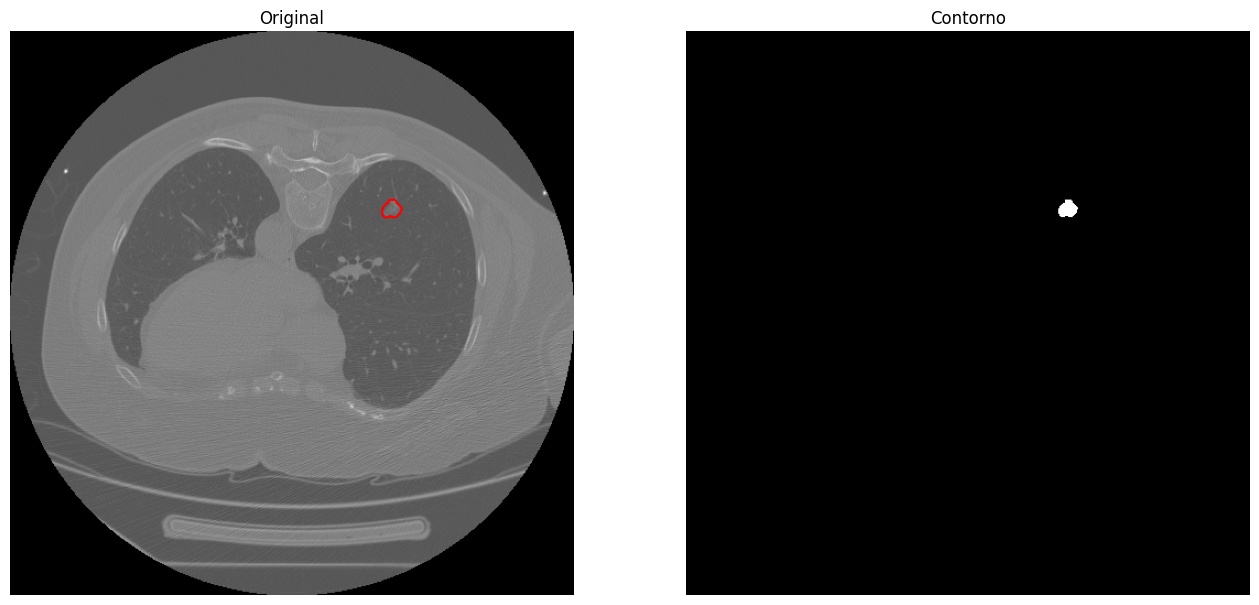

LIDC-IDRI-0939
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


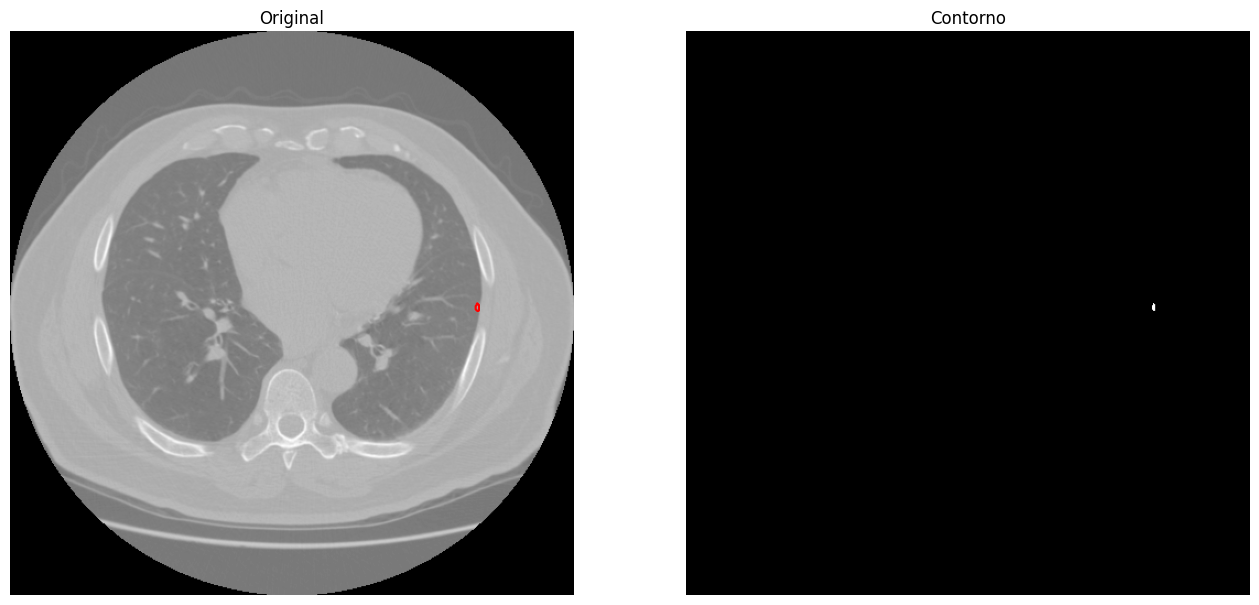

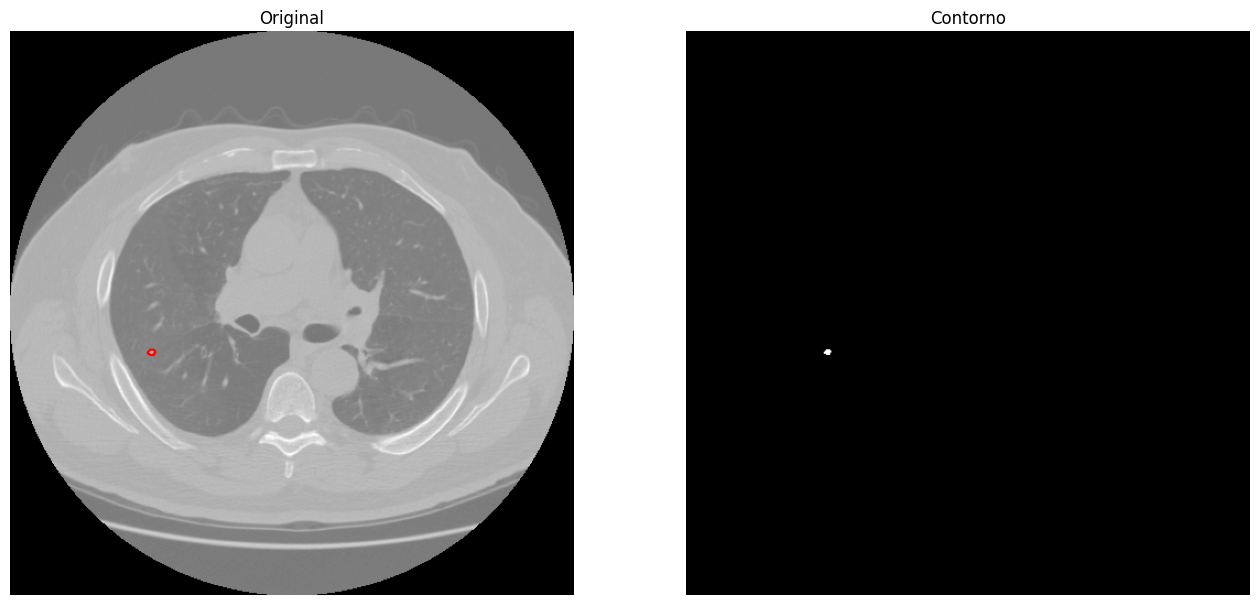

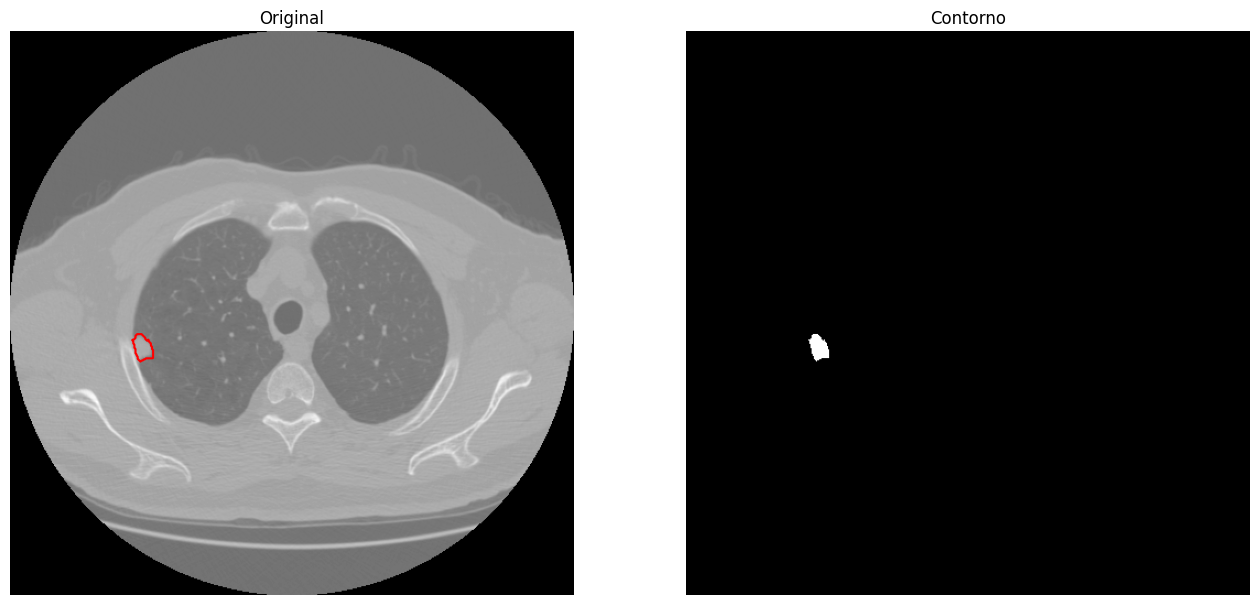

LIDC-IDRI-0940
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


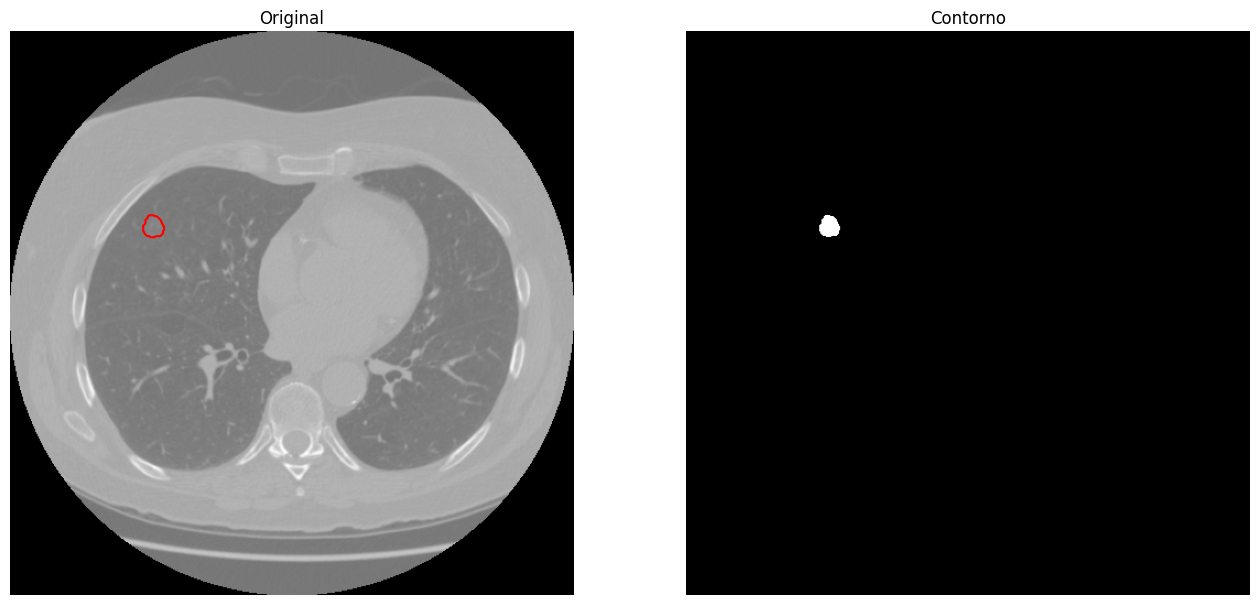

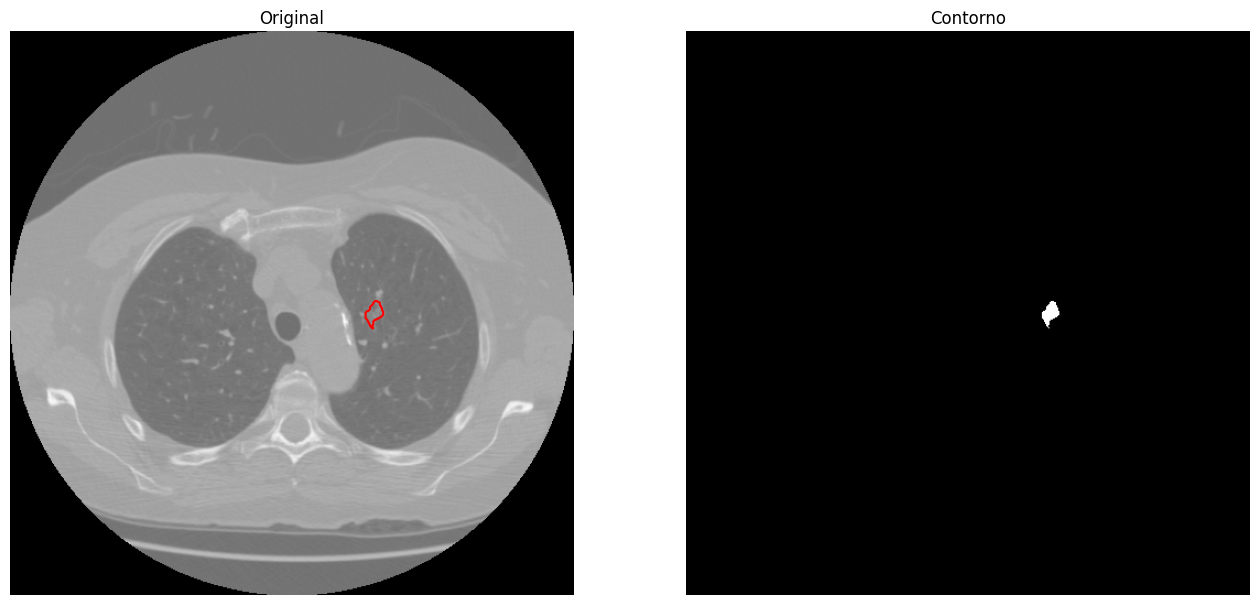

Pacientes não encontrados salvos no arquivo patients_none.txt


In [ ]:
params_file = "Params.yaml"

deleted_patients = []

dic_list = []

extractor = featureextractor.RadiomicsFeatureExtractor(params_file)


def isolate_nodules(base_masks_dir,folder):
    nodule_id=0
    for i in range(938,941): 
        patient_id = f"LIDC-IDRI-{i:04d}"

        print(patient_id)

        try:
            scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()

            if scan is None:
                raise ValueError(f"Scan não encontrado para {patient_id}")

            dicom_files = scan.load_all_dicom_images()

            vec_masks, vol, _ = get_nodule_coordinates(scan, patient_id)
            
            if vec_masks is None or vol is None:
                print(f"Nódulo ou volume não encontrado para {patient_id}.")
                continue

            for i in range(len(vec_masks)):
                nodule_id+=1
                
                img_slice, mask_slice, max_slice = isolate_nodule_with_coordinates(vec_masks[i], vol)

                #dicom_file_name = dicom_files[max_slice].SOPInstanceUID

                dicom_file = dicom_files[max_slice]

                # Normalizamos a imagem
                img_slice = normalize_image(img_slice)

                #print(patient_id)
                #print(nodule_id)

                intercept = dicom_file.RescaleIntercept
                slope = dicom_file.RescaleSlope

                # Convertemos para Hounsfield Units
                img_hu = img_slice * slope + intercept

                # Parte da visualização da máscara
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))

                axes[0].imshow(img_hu, cmap='gray')
                axes[0].contour(mask_slice, colors='r')
                axes[0].set_title('Original')
                axes[0].axis('off')

                axes[1].imshow(mask_slice, cmap='gray')
                axes[1].set_title('Contorno')
                axes[1].axis('off')

                plt.show()

                # Convertemos a imagem e a máscara para SimpleITK, que é um formato usado pelo radiomics
                img_sitk = sitk.GetImageFromArray(img_hu.astype(np.float32))
                mask_sitk = sitk.GetImageFromArray(mask_slice.astype(np.uint8))

                #print(img_sitk)
                #print(mask_sitk)

                # Finalmente extraímos as features usando o PyRadiomics
                features = extractor.execute(img_sitk, mask_sitk, label=1)
                dic_list.append(features)

                # Adicionamos PatientID e NoduleID às features para poder dar merge com o outro dataset
                features['PatientID'] = patient_id
                features['NoduleID'] = nodule_id

                # Salvamos a máscara isolada (opcional)
                #save_mask(mask_slice, patient_id, nodule_id[i], dicom_file_name, base_masks_dir)

        except Exception as e:
            # Se ocorrer um erro (como scan não encontrado), adicionar o paciente à lista de excluídos
            print(f"Erro ao processar {patient_id}: {e}")
            deleted_patients.append(patient_id)
            continue

    with open(folder, 'w') as arquivo:
        for element in deleted_patients:
            arquivo.write(element + '\n')
        print(f"Pacientes não encontrados salvos no arquivo {folder}")

base_masks_dir = "Masks"
folder = "patients_none.txt"

isolate_nodules(base_masks_dir,folder)

# Criamos o DataFrame a partir das features
features_df = pd.DataFrame(dic_list)

# Salvamos as features extraídas em um arquivo excel
output_csv = f"features_radiomics_2D.xlsx"
features_df.to_excel(output_csv, index=False)


<a id="mascaras-3d"></a>
## Máscaras 3D

[Go back to the top](#indice)

Por fim, nesta parte iremos criar as máscaras em 3D para na próxima fase, podermos discutir alguns resultados obtidos entre o 2D e o 3D. Este código é muito semelhante à extração de features em 2D. Ao invés de guardarmos a máscara da slice de maior área, guardamos a máscara total.


In [14]:
def isolate_nodule_3d(consensus_mask_full, vol):
    isolated_nodule_vol = vol * consensus_mask_full
    nodule_slices = np.any(consensus_mask_full, axis=(0, 1))
    
    if not np.any(nodule_slices):
        print("Nenhuma slice contém o nódulo.")
        return None
    
    # Filtra as slices para reduzir a carga
    min_slice, max_slice = np.where(nodule_slices)[0][[0, -1]]
    reduced_nodule_vol = isolated_nodule_vol[:, :, min_slice:max_slice + 1]
    
    return reduced_nodule_vol

Este excerto apenas serve para visualizar a máscara criada

In [22]:
def visualize_nodule_3d(nodule_vol):
    if not np.any(nodule_vol):
        print("O volume do nódulo está vazio.")
        return
    
    # Reduzir o tamanho da malha para melhorar a performance
    verts, faces, _, _ = measure.marching_cubes(nodule_vol, level=0, step_size=2)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.3, 0.3, 1, 1])
    ax.add_collection3d(mesh)
    
    x_min, x_max = verts[:, 0].min(), verts[:, 0].max()
    y_min, y_max = verts[:, 1].min(), verts[:, 1].max()
    z_min, z_max = verts[:, 2].min(), verts[:, 2].max()
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()

<a id="extracao-das-features"></a>
## Extração das features

[Go back to the top](#indice)

Por fim, é neste excerto de código onde são extraídas as features da máscara 3D de cada nódulo. Usamos o ficheiro Params3D e guardamos todas as features num csv para podermos estudá-lo de seguida. Caso queiramos visualizar alguma máscara é so retirar o comentário que chama a função "visualize_nodule_3d".

Decidimos implementar o 3D para podermos comparar com o uso de 2D e discutir acerca das vantagens e desvantagens destes dois métodos.

In [ ]:
params_file_3D = "Params3D.yaml"

def extract_radiomics_features(nodule_vol, nodule_mask):
    sitk_vol = sitk.GetImageFromArray(nodule_vol)
    sitk_mask = sitk.GetImageFromArray(nodule_mask.astype(np.uint8))
    
    extractor = featureextractor.RadiomicsFeatureExtractor(params_file_3D)

    result = extractor.execute(sitk_vol, sitk_mask)
    
    return result

def isolate_nodules():
    nodule_id=0
    all_features = []

    for i in range(1, 1013):
        patient_id = f"LIDC-IDRI-{i:04d}"

        try:
            scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
            if scan is None:
                raise ValueError(f"Scan não encontrado para {patient_id}")

            dicom_files = scan.load_all_dicom_images()
            vec_masks, vol, _ = get_nodule_coordinates(scan, patient_id)

            if vec_masks is None or vol is None:
                print(f"Nódulo ou volume não encontrado para {patient_id}.")
                continue

            for j in range(len(vec_masks)):
                nodule_id+=1
                
                #visualize_nodule_3d(vec_masks[j])

                features = extract_radiomics_features(vol, vec_masks[j])
                features['NoduleID'] = nodule_id 
                features['PatientID'] = patient_id  

                all_features.append(features)

        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            continue

    return all_features 



all_features = isolate_nodules()
output_csv = f"radiomics_features_3D.xlsx"
features_df = pd.DataFrame(all_features)  
features_df.to_excel(output_csv, index=False)


<a id="pre-processamento-2"></a>
## Pré Processamento 2

[Go back to the top](#indice)

Nesta fase iremos começar por analisar o dataset onde se encontram as features extraídas

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


Começamos por juntar o dataset criado anteriormente com o dataset criado pelo Pyradiomics, com base no PatientID e no NoduleID

In [ ]:
features_radiomics = pd.read_csv("features_radiomics.csv")
nodule_df2 = pd.read_csv("nodule_df.csv")

merged_df = pd.merge(nodule_df2, features_radiomics, on=['PatientID', 'NoduleID'], how='inner')

merged_df.to_csv(r"merged_data.csv", index=False)

print(merged_df.shape)

### Eliminação de colunas

Numa primeira abordagem iremos eliminar colunas de versões de bibliotecas e de configurações de imagens que são geradas pelo radiomics

columns_to_remove_image_diagnostics = Estas colunas geralmente descrevem propriedades técnicas da imagem, como tamanho, dimensionalidade, e outras características que não estão diretamente relacionadas às características radiômicas do nódulo.

In [ ]:
columns_to_remove_unecessary_PatientIDs = ['PatientID', 'NoduleID']

columns_to_remove_diagnostics_versions = [
    'diagnostics_Versions_PyRadiomics',
    'diagnostics_Versions_Numpy',
    'diagnostics_Versions_SimpleITK',
    'diagnostics_Versions_PyWavelet',
    'diagnostics_Versions_Python',
]

# Lista de colunas de diagnóstico de imagem para remover
'''
columns_to_remove_image_diagnostics = [
    'diagnostics_Configuration_Settings',
    'diagnostics_Configuration_EnabledImageTypes',
    'diagnostics_Image-original_Hash',
    'diagnostics_Image-original_Dimensionality',
    'diagnostics_Image-original_Spacing',
    'diagnostics_Image-original_Size',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_Hash',
    'diagnostics_Mask-original_Spacing',
    'diagnostics_Mask-original_Size',
    'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
    'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_CenterOfMass'
]

'''
merged_df.drop(columns=columns_to_remove_diagnostics_versions, inplace=True)
merged_df.drop(columns=columns_to_remove_unecessary_PatientIDs, inplace=True)

Aqui iremos apagar todas as colunas que têm apenas um valor único na sua totalidade

In [5]:
# Começamos por calcular o número de valores únicos por coluna
valores_unicos = merged_df.nunique()

# Imprimimos o número de valores únicos por coluna, ordenado do menor para o maior
print("Número de valores únicos por coluna (ordenado):")
print(valores_unicos.sort_values(ascending=True))

# Ordenamos o DataFrame pelas colunas com base no número de valores únicos
merged_df = merged_df.loc[:, valores_unicos.sort_values(ascending=False).index]

print("DataFrame ordenado por número de valores únicos (antes da remoção):")

# Por fim removemos as colunas que têm apenas um valor único
merged_df = merged_df.loc[:, merged_df.nunique() > 1]

# Aqui verificamos se algum nao foi eliminado
valores_unicos_final = merged_df.nunique()

print("Número de valores únicos por coluna no DataFrame final (ordenado):")
print(valores_unicos_final.sort_values(ascending=True))


Número de valores únicos por coluna (ordenado):
diagnostics_Configuration_EnabledImageTypes             1
diagnostics_Image-original_Size                         1
diagnostics_Image-original_Spacing                      1
diagnostics_Image-original_Dimensionality               1
diagnostics_Mask-original_Spacing                       1
                                                     ... 
original_firstorder_Kurtosis                         2624
original_glszm_LargeAreaLowGrayLevelEmphasis         2624
original_glszm_LowGrayLevelZoneEmphasis              2624
original_firstorder_TotalEnergy                      2624
original_gldm_SmallDependenceLowGrayLevelEmphasis    2624
Length: 121, dtype: int64
DataFrame ordenado por número de valores únicos (antes da remoção):
Número de valores únicos por coluna no DataFrame final (ordenado):
InternalStructure                                       4
Margin                                                  5
Lobulation                           

Como vimos acima, não temos qualquer valor binário que possa criar confusão com atributos não binários

### Tratamento de valores nulos e valores duplicados

Nesta etapa iremos verificar se existem valores nulos ou duplicados e caso hajam iremos removê-los

In [6]:
null_columns = merged_df.isna().sum()
null_columns = null_columns[null_columns > 0]

# Imprime apenas as colunas com valores nulos
print(null_columns)

Series([], dtype: int64)


In [7]:
print(f'Formato do dataset antes de remover valores duplicados: {merged_df.shape}')
loan_dataset = merged_df.drop_duplicates()
print(f'Formato do dataset depois de remover valores duplicados: {loan_dataset.shape}')

Formato do dataset antes de remover valores duplicados: (2624, 114)
Formato do dataset depois de remover valores duplicados: (2624, 114)


### Tratamento de valores não númericos

Iremos ver se o dataset tem valores que não são numericos, e que portanto necessitem de algum tipo de label Encoder, ou uma especial atenção nossa

In [8]:

# Filtramos as colunas que não têm dados do tipo int ou float
non_int_str_columns = merged_df.select_dtypes(exclude=['int', 'float',]).columns
print(non_int_str_columns)




Index(['diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Image-original_Hash'],
      dtype='object')


Como vimos em cima, podemos começar por remover as colunas 'diagnostics_Mask-original_Hash', 'diagnostics_Image-original_Hash', pois esses atributos representam hashes, que são códigos únicos gerados por uma função hash. Eles não têm significado numérico e podem ser removidos

In [9]:
columns_to_remove = ['diagnostics_Mask-original_Hash', 'diagnostics_Image-original_Hash']
merged_df = merged_df.drop(columns=columns_to_remove)
merged_df = merged_df.drop(columns = 'diagnostics_Mask-original_BoundingBox')

Em relação aos atributos do centro de massa pensamos em agrupar os nódulos com base nessa localização. A clusterização ajudará a identificar padrões de localização, como a presença de nódulos em regiões específicas dos pulmões, o que pode estar relacionado com a patologia subjacente. Para isso, o algoritmo K-Means é uma escolha natural, pois agrupa os pontos em clusters de forma esférica, com base na distância euclidiana

In [10]:
print(merged_df[['diagnostics_Mask-original_CenterOfMass', 
                 'diagnostics_Mask-original_CenterOfMassIndex', 
                 ]].head())

     diagnostics_Mask-original_CenterOfMass  \
0    (314.9232981783317, 366.0086289549377)   
1   (344.71860986547085, 360.7757847533632)   
2     (368.3704292527822, 347.268680445151)   
3  (366.05067985166875, 352.45117428924596)   
4                        (307.448, 198.072)   

  diagnostics_Mask-original_CenterOfMassIndex  
0      (314.9232981783317, 366.0086289549377)  
1     (344.71860986547085, 360.7757847533632)  
2       (368.3704292527822, 347.268680445151)  
3    (366.05067985166875, 352.45117428924596)  
4                          (307.448, 198.072)  


In [11]:
import ast

merged_df['diagnostics_Mask-original_CenterOfMass'] = merged_df['diagnostics_Mask-original_CenterOfMass'].apply(ast.literal_eval)
merged_df['diagnostics_Mask-original_CenterOfMassIndex'] = merged_df['diagnostics_Mask-original_CenterOfMassIndex'].apply(ast.literal_eval)

# Combinamos as coordenadas em um único array para usar na clusterização
merged_df['x_position'] = merged_df['diagnostics_Mask-original_CenterOfMass'].apply(lambda x: x[0])
merged_df['y_position'] = merged_df['diagnostics_Mask-original_CenterOfMassIndex'].apply(lambda x: x[1])

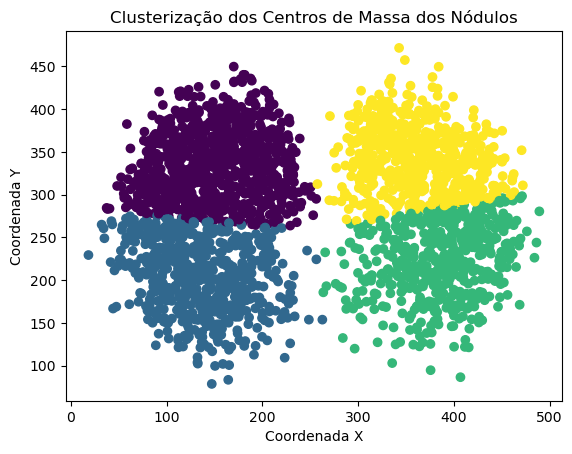

   x_position  y_position  Loc_Cluster
0  314.923298  366.008629            3
1  344.718610  360.775785            3
2  368.370429  347.268680            3
3  366.050680  352.451174            3
4  307.448000  198.072000            2


In [12]:
from sklearn.cluster import KMeans

# Começamos por preparar os dados para o K-Means
X = merged_df[['x_position', 'y_position']]

kmeans = KMeans(n_clusters=4, random_state=0)

merged_df['Loc_Cluster'] = kmeans.fit_predict(X)

plt.scatter(merged_df['x_position'], merged_df['y_position'], c=merged_df['Loc_Cluster'], cmap='viridis')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Clusterização dos Centros de Massa dos Nódulos')
plt.show()

print(merged_df[['x_position', 'y_position', 'Loc_Cluster']].head())



In [13]:
merged_df.drop(columns = ['diagnostics_Mask-original_CenterOfMass', 'diagnostics_Mask-original_CenterOfMassIndex'], inplace = True)


### Tratamento do atributo 'Malignancy'

Iremos agora avançar para a coluna "malignancy" que será a target dos nossos algoritmos e portanto requer maior cuidado

In [51]:
merged_df["Malignancy"].value_counts()

3    1064
2     644
1     411
4     285
5     220
Name: Malignancy, dtype: int64

Grande parte dos estudos relativos a este tema resumiu os valores de Malignancy [1,2,3,4,5] a 2 categorias:

    - Malignancy < 3   -> Nódulo Benigno  (0) 
    - Malignancy > 3   -> Nódulo Maligno  (1)

E todos os pacientes cuja Malignancy == 3 foram eliminados.

Deste modo, varios relatos indicam que os resultados das classificações são melhores com este agrupamento de Malignancys

'We used the schema suggested by Han et al. [20] and Wei et al. [29], where a lung nodule with a composite malignancy rate 1 or 2 is regarded as benign( 0 ), a rate 4 or 5 is regarded as malignant (1) and a rate of 3 has uncertain malignancy. Nodules rated at 3 can be discarded or regarded as benign or malignant' , as stated Fusing texture, shape and deep model-learned information at decision level for automated classification of lung nodules on chest CT [https://www.sciencedirect.com/science/article/pii/S1566253516301063]



In [14]:
# Removemos todos os nódulos classificados como 3
merged_df = merged_df[merged_df['Malignancy'] != 3]

# Reclassificamos os valores menores que 3 como 0 e maiores que 3 como 1
merged_df['Malignancy'] = merged_df['Malignancy'].apply(lambda x: 0 if x < 3 else 1)

# Exibimos a contagem dos novos valores da coluna Malignancy
print(merged_df['Malignancy'].value_counts())


0    1055
1     505
Name: Malignancy, dtype: int64


### Mudança de nomes dos atributos

De forma a simplificar o nosso dataset, visto que este tem diversos atributos e muitos deles com nomes bastante extensos iremos proceder à simplificação dos nomes de alguns atributos

In [15]:
column_mapping = {
    'InternalStructure': 'Internal_Struct',
    'Sphericity': 'Sphericity',
    'Calcification': 'Calcification',
    'Subtlety': 'Subtlety',
    'Lobulation': 'Lobulation',
    'Margin': 'Margin',
    'Spiculation': 'Spiculation',
    'Texture': 'Texture',
    'Malignancy': 'Malignancy',
    'original_shape2D_Elongation': 'Shape2D_Elongation',
    'original_shape2D_MajorAxisLength': 'Shape2D_MajorAxisLen',
    'original_shape2D_MaximumDiameter': 'Shape2D_MaxDiameter',
    'original_shape2D_MeshSurface': 'Shape2D_MeshSurface',
    'original_shape2D_MinorAxisLength': 'Shape2D_MinorAxisLen',
    'original_shape2D_Perimeter': 'Shape2D_Perimeter',
    'original_shape2D_PerimeterSurfaceRatio': 'Shape2D_PerimeterSurfRatio',
    'original_shape2D_PixelSurface': 'Shape2D_PixelSurface',
    'original_shape2D_Sphericity': 'Shape2D_Sphericity',
    'original_firstorder_10Percentile': 'FirstOrder_10Percentile',
    'original_firstorder_90Percentile': 'FirstOrder_90Percentile',
    'original_firstorder_Energy': 'FirstOrder_Energy',
    'original_firstorder_Entropy': 'FirstOrder_Entropy',
    'original_firstorder_InterquartileRange': 'FirstOrder_IQR',
    'original_firstorder_Kurtosis': 'FirstOrder_Kurtosis',
    'original_firstorder_Maximum': 'FirstOrder_Max',
    'original_firstorder_MeanAbsoluteDeviation': 'FirstOrder_MAD',
    'original_firstorder_Mean': 'FirstOrder_Mean',
    'original_firstorder_Median': 'FirstOrder_Median',
    'original_firstorder_Minimum': 'FirstOrder_Min',
    'original_firstorder_Range': 'FirstOrder_Range',
    'original_firstorder_RobustMeanAbsoluteDeviation': 'FirstOrder_RMAD',
    'original_firstorder_RootMeanSquared': 'FirstOrder_RMS',
    'original_firstorder_Skewness': 'FirstOrder_Skewness',
    'original_firstorder_TotalEnergy': 'FirstOrder_TotalEnergy',
    'original_firstorder_Uniformity': 'FirstOrder_Uniformity',
    'original_firstorder_Variance': 'FirstOrder_Variance',
    'original_glcm_Autocorrelation': 'GLCM_Autocorr',
    'original_glcm_JointAverage': 'GLCM_JointAvg',
    'original_glcm_ClusterProminence': 'GLCM_ClusterProm',
    'original_glcm_ClusterShade': 'GLCM_ClusterShade',
    'original_glcm_ClusterTendency': 'GLCM_ClusterTend',
    'original_glcm_Contrast': 'GLCM_Contrast',
    'original_glcm_Correlation': 'GLCM_Corr',
    'original_glcm_DifferenceAverage': 'GLCM_DiffAvg',
    'original_glcm_DifferenceEntropy': 'GLCM_DiffEntropy',
    'original_glcm_DifferenceVariance': 'GLCM_DiffVariance',
    'original_glcm_JointEnergy': 'GLCM_JointEnergy',
    'original_glcm_JointEntropy': 'GLCM_JointEntropy',
    'original_glcm_Imc1': 'GLCM_IMC1',
    'original_glcm_Imc2': 'GLCM_IMC2',
    'original_glcm_Idm': 'GLCM_IDM',
    'original_glcm_Idmn': 'GLCM_IDMN',
    'original_glcm_Id': 'GLCM_ID',
    'original_glcm_Idn': 'GLCM_IDN',
    'original_glcm_InverseVariance': 'GLCM_InvVariance',
    'original_glcm_MaximumProbability': 'GLCM_MaxProb',
    'original_glcm_SumEntropy': 'GLCM_SumEntropy',
    'original_glcm_SumSquares': 'GLCM_SumSquares',
    'original_glrlm_GrayLevelNonUniformity': 'GLRLM_GrayLevelNonUni',
    'original_glrlm_GrayLevelNonUniformityNormalized': 'GLRLM_GrayLevelNonUniNorm',
    'original_glrlm_GrayLevelVariance': 'GLRLM_GrayLevelVar',
    'original_glrlm_HighGrayLevelRunEmphasis': 'GLRLM_HighGrayRunEmph',
    'original_glrlm_LongRunEmphasis': 'GLRLM_LongRunEmph',
    'original_glrlm_LongRunHighGrayLevelEmphasis': 'GLRLM_LongRunHighGrayEmph',
    'original_glrlm_LongRunLowGrayLevelEmphasis': 'GLRLM_LongRunLowGrayEmph',
    'original_glrlm_LowGrayLevelRunEmphasis': 'GLRLM_LowGrayRunEmph',
    'original_glrlm_RunEntropy': 'GLRLM_RunEntropy',
    'original_glrlm_RunLengthNonUniformity': 'GLRLM_RunLenNonUni',
    'original_glrlm_RunLengthNonUniformityNormalized': 'GLRLM_RunLenNonUniNorm',
    'original_glrlm_RunPercentage': 'GLRLM_RunPerc',
    'original_glrlm_RunVariance': 'GLRLM_RunVar',
    'original_glrlm_ShortRunEmphasis': 'GLRLM_ShortRunEmph',
    'original_glrlm_ShortRunHighGrayLevelEmphasis': 'GLRLM_ShortRunHighGrayEmph',
    'original_glrlm_ShortRunLowGrayLevelEmphasis': 'GLRLM_ShortRunLowGrayEmph',
    'original_glszm_GrayLevelNonUniformity': 'GLSZM_GrayLevelNonUni',
    'original_glszm_GrayLevelNonUniformityNormalized': 'GLSZM_GrayLevelNonUniNorm',
    'original_glszm_GrayLevelVariance': 'GLSZM_GrayLevelVar',
    'original_glszm_HighGrayLevelZoneEmphasis': 'GLSZM_HighGrayZoneEmph',
    'original_glszm_LargeAreaEmphasis': 'GLSZM_LargeAreaEmph',
    'original_glszm_LargeAreaHighGrayLevelEmphasis': 'GLSZM_LargeAreaHighGrayEmph',
    'original_glszm_LargeAreaLowGrayLevelEmphasis': 'GLSZM_LargeAreaLowGrayEmph',
    'original_glszm_LowGrayLevelZoneEmphasis': 'GLSZM_LowGrayZoneEmph',
    'original_glszm_SizeZoneNonUniformity': 'GLSZM_SizeZoneNonUni',
    'original_glszm_SizeZoneNonUniformityNormalized': 'GLSZM_SizeZoneNonUniNorm',
    'original_glszm_SmallAreaEmphasis': 'GLSZM_SmallAreaEmph',
    'original_glszm_SmallAreaHighGrayLevelEmphasis': 'GLSZM_SmallAreaHighGrayEmph',
    'original_glszm_SmallAreaLowGrayLevelEmphasis': 'GLSZM_SmallAreaLowGrayEmph',
    'original_glszm_ZoneEntropy': 'GLSZM_ZoneEntropy',
    'original_glszm_ZonePercentage': 'GLSZM_ZonePerc',
    'original_glszm_ZoneVariance': 'GLSZM_ZoneVar',
    'original_gldm_DependenceEntropy': 'GLDM_DependEntropy',
    'original_gldm_DependenceNonUniformity': 'GLDM_DependNonUni',
    'original_gldm_DependenceNonUniformityNormalized': 'GLDM_DependNonUniNorm',
    'original_gldm_DependenceVariance': 'GLDM_DependVar',
    'original_gldm_GrayLevelNonUniformity': 'GLDM_GrayLevelNonUni',
    'original_gldm_GrayLevelVariance': 'GLDM_GrayLevelVar',
    'original_gldm_HighGrayLevelEmphasis': 'GLDM_HighGrayEmph',
    'original_gldm_LargeDependenceEmphasis': 'GLDM_LargeDependEmph',
    'original_gldm_LargeDependenceHighGrayLevelEmphasis': 'GLDM_LargeDependHighGrayEmph',
    'original_gldm_LargeDependenceLowGrayLevelEmphasis': 'GLDM_LargeDependLowGrayEmph',
    'original_gldm_LowGrayLevelEmphasis': 'GLDM_LowGrayEmph',
    'original_gldm_SmallDependenceEmphasis': 'GLDM_SmallDependEmph',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis': 'GLDM_SmallDependHighGrayEmph',
    'original_gldm_SmallDependenceLowGrayLevelEmphasis': 'GLDM_SmallDependLowGrayEmph'
}

merged_df.rename(columns=column_mapping, inplace=True)
merged_df.columns



Index(['GLDM_SmallDependLowGrayEmph', 'GLSZM_LowGrayZoneEmph', 'GLCM_IDN',
       'FirstOrder_Energy', 'FirstOrder_Kurtosis', 'GLRLM_ShortRunLowGrayEmph',
       'GLCM_IDMN', 'FirstOrder_MAD', 'GLRLM_LongRunLowGrayEmph',
       'GLSZM_LargeAreaLowGrayEmph',
       ...
       'Spiculation', 'Texture', 'Subtlety', 'Sphericity', 'Malignancy',
       'diagnostics_Mask-original_VolumeNum', 'Internal_Struct', 'x_position',
       'y_position', 'Loc_Cluster'],
      dtype='object', length=112)

Claramente o dataset tem demasiados atributos que provavelmente nada acrescentarão aos nossos modelos de ML. Com isso em mente, na proxima secção iremos proceder à seleção das features que serão utilizados nos nossos modelos

<a id="feature-selection"></a>
## Feature Selection

[Go back to the top](#indice)

Para a seleção das melhores features iremos proceder a vários tipos de métodos que consigam medir a relevância dos mesmos

###  Métodos estatísticos


Para identificar as features mais relevantes para o nosso problema, aplicamos um estatísticos de seleção de atributos, a regularização L1, que utiliza a Regressão Logística com uma penalização que força alguns coeficientes a zero. Isso ajuda a eliminar atributos irrelevantes, mantendo apenas aqueles que contribuem para o modelo de forma significativa


Para o uso da Lasso Regression para Features Selection baseamo-nos no estudo 'Feature selection methods and predictive models in CT lung cancer radiomics; Gary Ge 1, Jie Zhang' [https://pmc.ncbi.nlm.nih.gov/articles/PMC9860004/#acm213869-sec-0010] , que afirma:


'Figure 5 shows the distribution of feature selection methods in prognostic studies, which is very similar to that of classification studies. This suggests that the approach to both classification and prognostics studies is quite similar at the feature selection stage. The feature selection method that has become most commonly used in both classification and prognostic studies is LASSO'

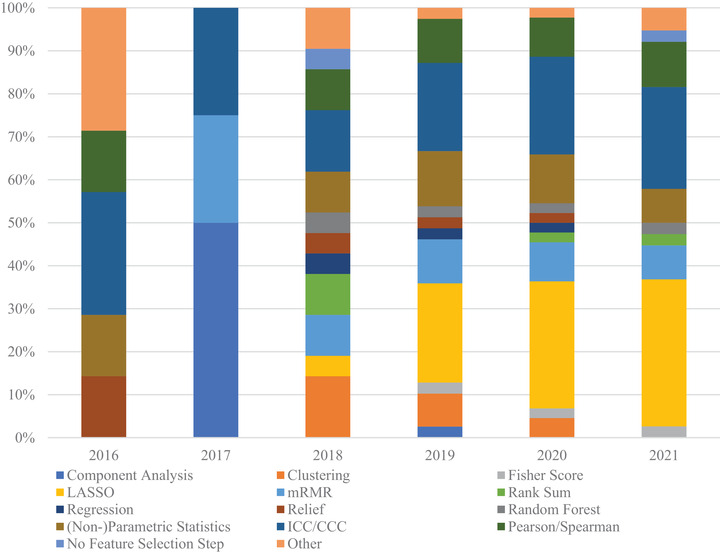

In [54]:
Image(filename=r"ACM2-24-e13869-g005.jpg")

In [16]:

X = merged_df.drop(columns=['Malignancy'])  # Features
y = merged_df['Malignancy']  # Alvo

# Normalizamos os dados usando o StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividimos em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Valores de C para testar
C_values = [0.05, 0.1, 1.0]

# Listas para armazenar as features selecionadas
selected_features_c0_01 = []
selected_features_c0_1 = []
selected_features_c1_0 = []

# Testamos com cada valor de C
for C in C_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model.fit(X_train, y_train)

    coef = model.coef_

    # Se coef for uma matriz 2D (problema multiclasse), use apenas os coeficientes da primeira classe
    if coef.ndim > 1:
        coef = coef[0]

    # Selecionamos as features com coeficientes diferentes de zero
    selected_features = X.columns[(coef != 0).ravel()]

    if C == 0.05:
        selected_features_L1_005 = selected_features
    elif C == 0.1:
        selected_features_L1_01 = selected_features
    elif C == 1.0:
        selected_features_L1_1 = selected_features

# Por fim imprimimos as features selecionadas para cada valor de C
print("Selected features after L1 Regularization for C=0.01:", selected_features_L1_005)
print("Selected features after L1 Regularization for C=0.1:", selected_features_L1_01)
print("Selected features after L1 Regularization for C=1.0:", selected_features_L1_1)




Selected features after L1 Regularization for C=0.01: Index(['GLCM_IMC1', 'Shape2D_MinorAxisLen', 'Shape2D_MajorAxisLen',
       'GLCM_JointEntropy', 'Shape2D_PerimeterSurfRatio', 'Shape2D_Sphericity',
       'GLDM_DependVar', 'FirstOrder_Min', 'Calcification', 'Margin',
       'Lobulation', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct'],
      dtype='object')
Selected features after L1 Regularization for C=0.1: Index(['FirstOrder_Skewness', 'GLCM_ClusterProm', 'GLCM_ClusterShade',
       'GLCM_IMC1', 'Shape2D_MinorAxisLen', 'Shape2D_MajorAxisLen',
       'GLCM_JointEntropy', 'Shape2D_Sphericity', 'GLSZM_ZoneVar',
       'GLRLM_RunVar', 'GLDM_DependVar', 'FirstOrder_Min',
       'diagnostics_Image-original_Minimum', 'Calcification', 'Margin',
       'Lobulation', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct'],
      dtype='object')
Selected features after L1 Regularization for C=1.0: Index(['FirstOrder_Energy', 'FirstOrder_Kurtosis', 'GLCM_IDMN',
       'GLRLM_LongR

### Métodos Baseados em Modelos

#### RANDOM FOREST CLASSIFIER

O mesmo estudo citado para o Lasso regression menciona a grande populariedade do algoritmo do Random Forest para a seleção de features radiomicos, e portanto decidimos também usar esse algoritmo para selecionar features

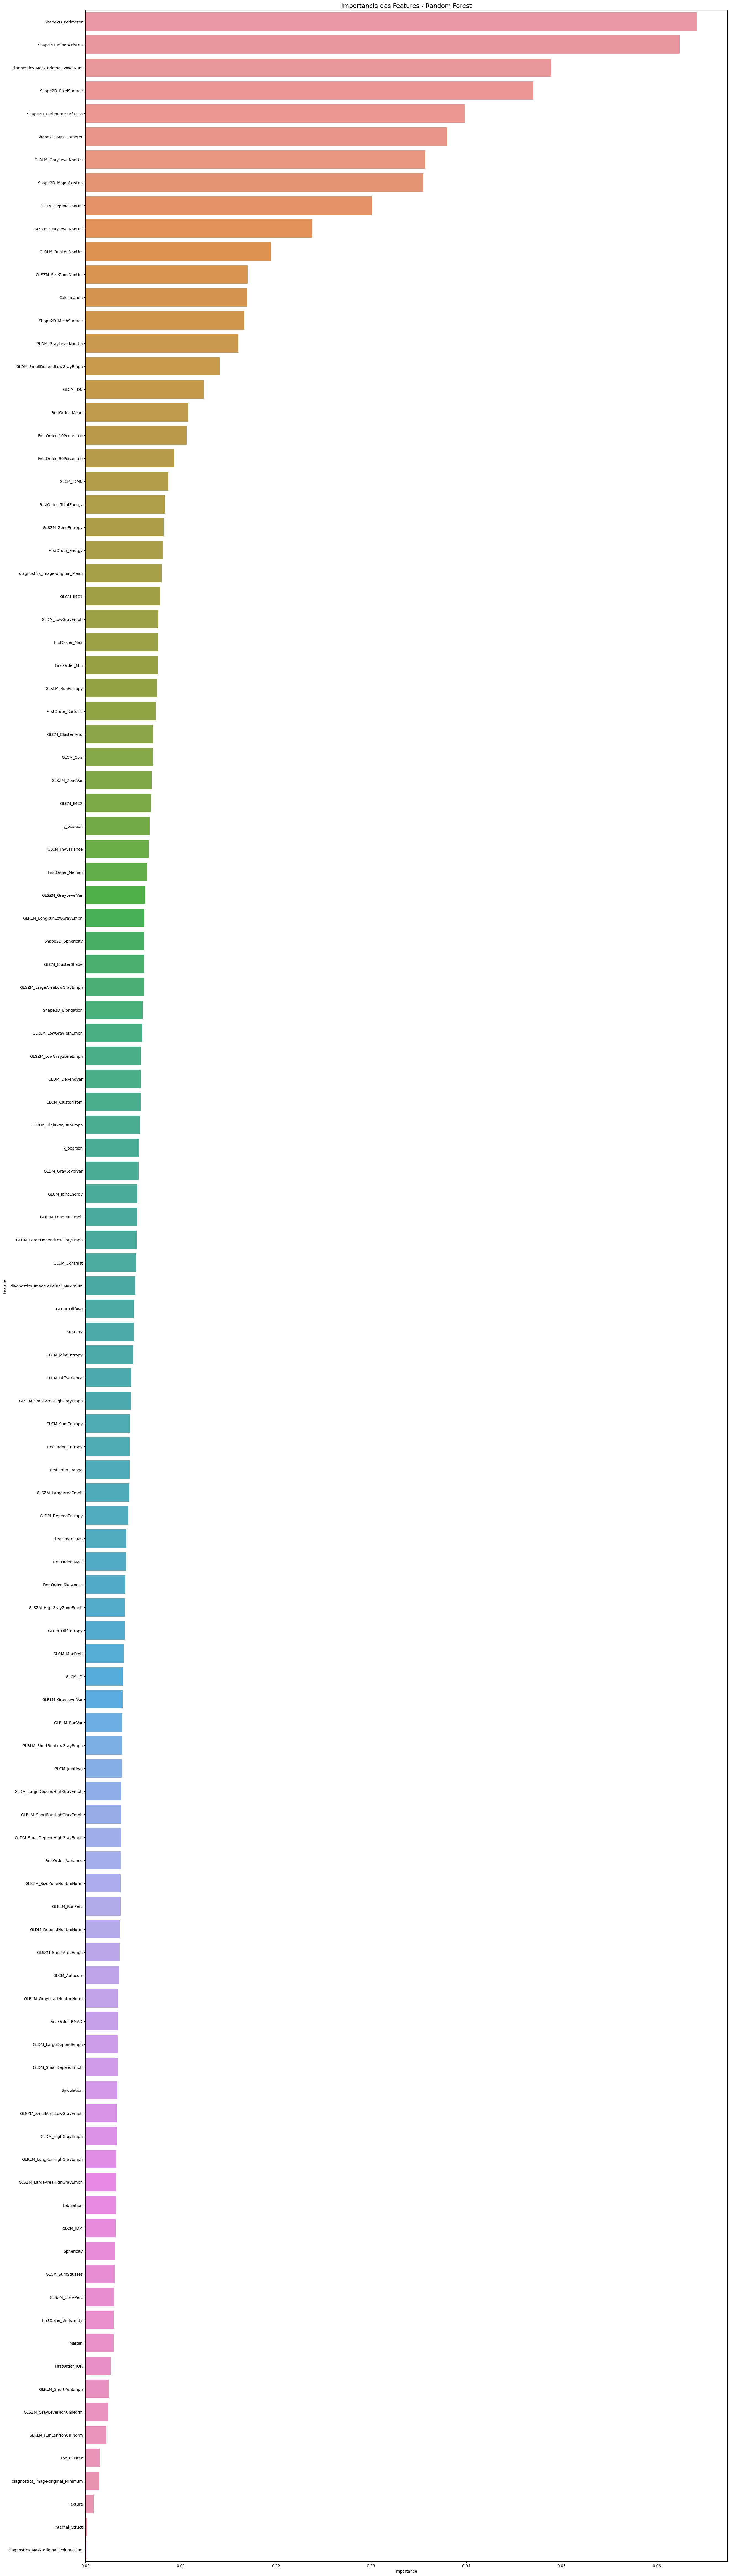

Top N Features selecionadas: ['Shape2D_Perimeter', 'Shape2D_MinorAxisLen', 'diagnostics_Mask-original_VoxelNum', 'Shape2D_PixelSurface', 'Shape2D_PerimeterSurfRatio', 'Shape2D_MaxDiameter', 'GLRLM_GrayLevelNonUni', 'Shape2D_MajorAxisLen', 'GLDM_DependNonUni', 'GLSZM_GrayLevelNonUni', 'GLRLM_RunLenNonUni', 'GLSZM_SizeZoneNonUni', 'Calcification', 'Shape2D_MeshSurface', 'GLDM_GrayLevelNonUni', 'GLDM_SmallDependLowGrayEmph', 'GLCM_IDN', 'FirstOrder_Mean', 'FirstOrder_10Percentile', 'FirstOrder_90Percentile']


In [17]:

# Definimos as variáveis independentes (X) e dependentes (y)
X = merged_df.drop(columns=['Malignancy']) 
y = merged_df['Malignancy'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Importância das features
importances = rf_model.feature_importances_

# Criamos um DataFrame para visualizar as importâncias
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenamos o DataFrame pela importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(30, 120))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importância das Features - Random Forest', fontsize=16)
plt.show()

# Selecionar as top N features (por exemplo, as 10 mais importantes)
combined_features_tree = feature_importances.head(20)['Feature'].tolist()
print("Top N Features selecionadas:", combined_features_tree)



### Wrapper Methods

#### RFE Method


RFE (Recursive Feature Elimination) é uma técnica de seleção de atributos que faz parte dos chamados wrapper methods. Funciona iterativamente, eliminando os atributos menos importantes do modelo a cada etapa, até que o número desejado de atributos seja alcançado.

In [20]:
model = LogisticRegression(max_iter=1000)

# Diferentes valores de n para as features
n_features_list = [10, 15, 20]

selected_features_rfe_10 = []
selected_features_rfe_15 = []
selected_features_rfe_20 = []

for n_features in n_features_list:
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    selected_features = X.columns[rfe.support_].tolist()
    
    # Para cada valor guarda o numero de atributos
    if n_features == 10:
        selected_features_rfe_10 = selected_features
    elif n_features == 15:
        selected_features_rfe_15 = selected_features
    elif n_features == 20:
        selected_features_rfe_20 = selected_features

print("Selected features with RFE (n_features_to_select=5):", selected_features_rfe_10)
print("Selected features with RFE (n_features_to_select=10):", selected_features_rfe_15)
print("Selected features with RFE (n_features_to_select=15):", selected_features_rfe_20)



c:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Selected features with RFE (n_features_to_select=5): ['GLCM_IMC1', 'GLCM_Corr', 'GLCM_SumEntropy', 'Shape2D_PerimeterSurfRatio', 'Shape2D_Sphericity', 'GLDM_LargeDependEmph', 'GLSZM_LargeAreaEmph', 'Calcification', 'Subtlety', 'Internal_Struct']
Selected features with RFE (n_features_to_select=10): ['FirstOrder_Skewness', 'GLCM_IMC1', 'GLCM_Corr', 'GLCM_InvVariance', 'FirstOrder_Entropy', 'GLCM_SumEntropy', 'Shape2D_PerimeterSurfRatio', 'Shape2D_Sphericity', 'GLDM_LargeDependEmph', 'GLSZM_LargeAreaEmph', 'Calcification', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct']
Selected features with RFE (n_features_to_select=15): ['FirstOrder_Skewness', 'GLCM_IMC1', 'GLCM_IDM', 'GLCM_Corr', 'GLCM_InvVariance', 'FirstOrder_Entropy', 'GLCM_SumEntropy', 'FirstOrder_Uniformity', 'Shape2D_PerimeterSurfRatio', 'GLRLM_GrayLevelNonUniNorm', 'GLSZM_GrayLevelNonUniNorm', 'Shape2D_Sphericity', 'GLDM_DependNonUniNorm', 'GLDM_LargeDependEmph', 'GLSZM_LargeAreaEmph', 'Calcification', 'Spiculation', 

### Correlação

Podemos também ver quais são os atributos com maior correlação com o atributo 'Malignancy' e observar que cada atributo cuja correlação está acima do treshold  está contido em pelo menos numa das listas para cada algoritmo de seleção de features

Top 15 features:
Index(['Malignancy', 'Shape2D_MinorAxisLen', 'Shape2D_MajorAxisLen',
       'Shape2D_MaxDiameter', 'Shape2D_Perimeter',
       'Shape2D_PerimeterSurfRatio', 'GLCM_IMC1', 'Shape2D_PixelSurface',
       'diagnostics_Mask-original_VoxelNum', 'Shape2D_MeshSurface',
       'GLRLM_RunLenNonUni', 'GLSZM_SizeZoneNonUni', 'GLDM_DependNonUni',
       'GLCM_IDN', 'GLDM_DependVar'],
      dtype='object')


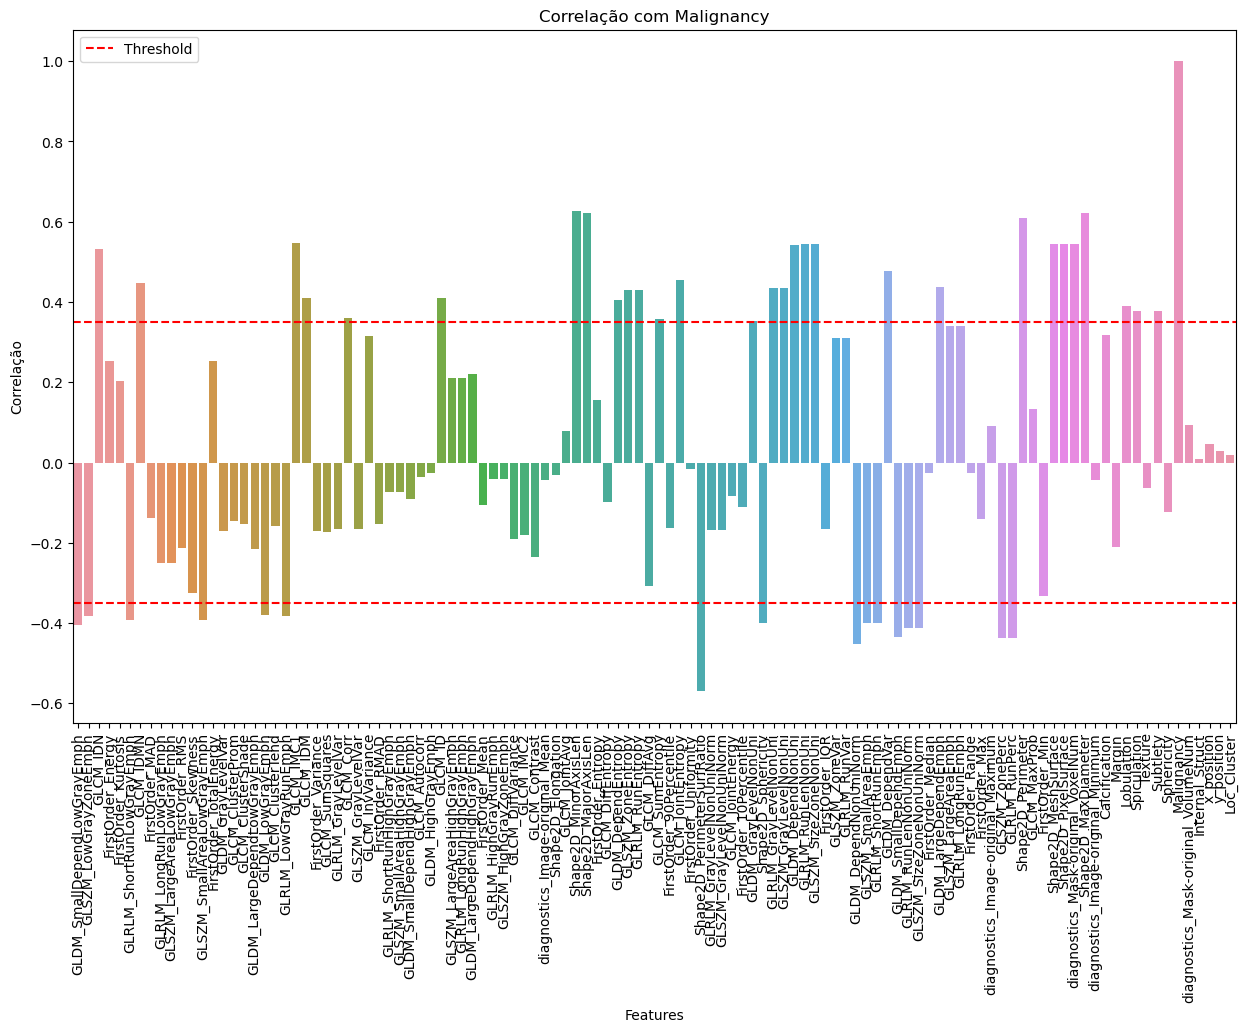

In [18]:

# Definimos o threshold para a correlação
correlation_threshold = 0.35

# Calculamos a correlação de cada features em relação ao atributo 'Malignancy' 
correlation_with_malignancy = merged_df.corr()['Malignancy']

high_correlation_features = correlation_with_malignancy[correlation_with_malignancy.abs() >= correlation_threshold]

# Obtemos as 15 features com correlação mais alta
high_correlation_features = high_correlation_features.abs().nlargest(15).index

print("Top 15 features:")
print(high_correlation_features)

plt.figure(figsize=(15, 9))
sns.barplot(x=correlation_with_malignancy.index, y=correlation_with_malignancy)
plt.xticks(rotation=90)
plt.title('Correlação com Malignancy')
plt.xlabel('Features')
plt.ylabel('Correlação')
plt.axhline(y=correlation_threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-correlation_threshold, color='r', linestyle='--')
plt.legend()
plt.show()


Após estas alterações acima descritas ficamos com estes conjuntos de features.

selected_features_L1_005, selected_features_L1_01, selected_features_L1_1,
combined_features_tree, selected_features_rfe_10, selected_features_rfe_15, selected_features_rfe_20, high_correlation_features

<a id="modelos-ml"></a>
## MODELOS ML

[Go back to the top](#indice)

Após o pré processamento e a seleção de features podemos avançar para o desenvolvimento dos modelos Machine Learning. É aqui que iremos aplicar todos os passos efetuados atrás e observar o comportamento de três algoritmos diferentes de Machine Learning

In [ ]:
feature_sets = {
    'L1_005': selected_features_L1_005,
    'L1_01': selected_features_L1_01,
    'L1_1': selected_features_L1_1,
    'Combined_Tree': combined_features_tree,
    'RFE_10': selected_features_rfe_10,
    'RFE_15': selected_features_rfe_15,
    'RFE_20': selected_features_rfe_20,
    
}

As métricas usadas para avaliar foram a accuracy, a precision, recall, f1 score e AUC-ROC.

In [22]:

def calculate_metrics(y_true, y_pred, y_prob):
    # Calcular as métricas de precisão, recall e f1
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    if len(y_prob.shape) > 1:
        y_prob = y_prob[:, 1]  # Pega as probabilidades da classe positiva
    
    # Calcular AUC-ROC
    roc_auc = roc_auc_score(y_true, y_prob)  # Para o caso binário

    return accuracy, precision, recall, f1, roc_auc


def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)  # Probabilidades para AUC-ROC
    return y_pred, y_prob


def run_experiment(feature_sets, merged_df, model):
    metrics_list = []

    for feature_set_name, features in feature_sets.items():
        X = merged_df[features]
        y = merged_df['Malignancy'].values.flatten()
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        y_pred, y_prob = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)

        accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_test, y_pred, y_prob)
        
        metrics_list.append({
            'Feature_Set': feature_set_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': roc_auc
        })
    
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.sort_values(by='AUC-ROC', ascending=False, inplace=True)  # Decidimos ordenar pelos melhores resultados de AUC-ROC
    return metrics_df



### RANDOM FOREST

O primeiro algoritmo de classificação que usaremos será o algoritmo Random Forest. Esta decisão foi baseado no seguinte estudo, onde este obteve excelentes resultados.

Enhanced lung cancer detection: Integrating improved random walker segmentation with artificial neural network and random forest classifier
Sneha S. Nair a, V.N. Meena Devi a, Saju Bhasi b [https://www.sciencedirect.com/science/article/pii/S2405844024050631]

In [23]:
rf_model = RandomForestClassifier(random_state=42)

metrics_RF_df = run_experiment(feature_sets, merged_df, rf_model)

print(metrics_RF_df)

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1          L1_01  0.878205   0.927711  0.706422  0.802083  0.936300
0         L1_005  0.875000   0.906977  0.715596  0.800000  0.936096
2           L1_1  0.871795   0.925926  0.688073  0.789474  0.926899
5         RFE_15  0.871795   0.936709  0.678899  0.787234  0.914742
3  Combined_Tree  0.855769   0.872093  0.688073  0.769231  0.911918
6         RFE_20  0.875000   0.937500  0.688073  0.793651  0.911307
4         RFE_10  0.868590   0.904762  0.697248  0.787565  0.909138


### XGBoost

De seguida iremos utilizar o algoritmo XGBoost, onde os parâmetros usados foram baseados no estudo de Nasiri e Hasani, intitulado "Automated detection of COVID-19 cases from chest X-ray images using deep neural network and XGBoost" (2021) [https://arxiv.org/abs/2109.02428].

Nesse estudo, os autores combinaram redes neurais profundas para extração de características de imagens de raio-X de tórax com o algoritmo XGBoost para realizar a classificação. O uso do XGBoost foi fundamental para atingir uma excelente performance de classificação, aproveitando a sua capacidade de modelar dados complexos e capturar interações não lineares nas características extraídas.

Os resultados obtidos com esta abordagem foram igualmente excelentes o que demonstram a eficácia do XGBoost em capturar padrões complexos em imagens médicas.

In [24]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,         
    learning_rate=0.44,
    gamma=0,                  # Lagrange multiplier
    max_depth=6,              # Profundidade máxima das árvores
    random_state=42,          
    use_label_encoder=False,  # Evitar warnings relacionados ao label encoder
    eval_metric='mlogloss'    # Função de avaliação
)

metrics_XGB_df = run_experiment(feature_sets, merged_df, xgb_model)

print(metrics_XGB_df)





c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\anaconda3\lib\site-packages\

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
2           L1_1  0.897436   0.942529  0.752294  0.836735  0.945677
0         L1_005  0.887821   0.911111  0.752294  0.824121  0.940164
1          L1_01  0.871795   0.887640  0.724771  0.797980  0.938853
3  Combined_Tree  0.852564   0.870588  0.678899  0.762887  0.919510
6         RFE_20  0.865385   0.885057  0.706422  0.785714  0.913273
5         RFE_15  0.839744   0.864198  0.642202  0.736842  0.907534
4         RFE_10  0.865385   0.885057  0.706422  0.785714  0.901523


c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### SVM 

Por fim decidimos implementar o algoritmo de SVM uma vez que, como mencionado neste estudo 'Classification of Benign and Malignant Lung Nodules Based on Deep Convolutional Network Feature Extraction, Enhui Lv,1 Wenfeng Liu,2 Pengbo Wen ,1 and Xingxing Kang1' é um algoritmo capaz de obter excelentes resultados neste contexto. Para a escolha do kernel utilizado na SVM realizaremos uma validação cruzada comparando o desempenho de diferentes kernels (RBF, polinomial, sigmóide). Deliberadamente não utilizaremos o kernel linear porque os dados do nosso problema claramente não são linearmente separaveis

In [ ]:
# Definimos uma lista de kernels para testar
kernels = ['poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    model = SVC(kernel=kernel, C=1, gamma='scale', probability=True, random_state=42)
    # Aqui é calculada a média da AUC-ROC em 5 folds
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    results[kernel] = scores.mean()  # Aqui é a média da AUC-ROC para cada kernel
    print(f"Kernel: {kernel}, Média AUC-ROC: {scores.mean()}")

best_kernel = max(results, key=results.get)
print(f"\nMelhor kernel: {best_kernel} com média AUC-ROC: {results[best_kernel]}")

model = SVC(kernel= best_kernel, C=1, probability=True, random_state=42)


metrics_SVM_df = run_experiment(feature_sets, merged_df, model)
print(metrics_SVM_df)


Kernel: poly, Média AUC-ROC: 0.8407770634883394
Kernel: rbf, Média AUC-ROC: 0.8325653418422411
Kernel: sigmoid, Média AUC-ROC: 0.6845666557177046

Melhor kernel: poly com média AUC-ROC: 0.8407770634883394


c:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
5         RFE_15  0.878205   0.917647  0.715596  0.804124  0.930944
6         RFE_20  0.871795   0.896552  0.715596  0.795918  0.927984
4         RFE_10  0.875000   0.897727  0.724771  0.802030  0.924142
3  Combined_Tree  0.804487   0.961538  0.458716  0.621118  0.904551
0         L1_005  0.746795   0.941176  0.293578  0.447552  0.892597
2           L1_1  0.653846   1.000000  0.009174  0.018182  0.769286
1          L1_01  0.650641   0.000000  0.000000  0.000000  0.701677


### Resultados obtidos (Acho que ali não é TP mas sim FN)

Iremos agora realçar os 3 melhores conjuntos de atributos para cada algoritmo usado.

- Para o algoritmo de Random forest os 3 conjuntos de atributos que obtiveram melhores resultados foram:
                - L1_1
                - L1_01
                - L1_005
- Para o algoritmo de XGB os 3 conjuntos de atributos que obtiveram melhores resultados foram:
                - L1_1
                - L1_01
                - L1_005

- Para o algoritmo de XGB os 3 conjuntos de atributos que obtiveram melhores resultados foram:
                - RFE_15
                - RFE_20
                - RFE_10

De forma a tentar melhorar a performance destes algoritmos iremos verificar se a nossa classe apresenta algum problema de desbalanceamento.

IREMOS AGORA TENTAR MELHORAR A PERFORMANCE DOS 3 ALGORITMOS APLICANDO NOVAS TÉCNICAS DE PROCESSAMENTO DE DADOS


In [64]:
merged_df["Malignancy"].value_counts()

0    1055
1     505
Name: Malignancy, dtype: int64

Através da análise dos dados, podemos ver que estes estão desbalanceados. Para combater isso iremos usar SMOTE que cria exemplos sintéticos da classe em menor número.

Os valores de 𝑘 e random state foram adotados com base no estudo de Yuting Yang e Golrokh Mirzaei, 

'Yang, Y., & Mirzaei, G. Performance analysis of data resampling on class imbalance and classification techniques  for cancer classification' [https://pmc.ncbi.nlm.nih.gov/articles/PMC10903850/#sec002]

que analisou a eficácia do SMOTE em contextos de desbalanceamento de classes em problemas de classificação de cancro do pulmão.







In [26]:
from imblearn.over_sampling import SMOTE

X = merged_df.drop('Malignancy', axis=1)
y = merged_df['Malignancy']

smote = SMOTE(random_state=42, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X, y)

merged_df = pd.concat([pd.DataFrame(X_bal, columns=X.columns), pd.DataFrame(y_bal, columns=['Malignancy'])], axis=1)

print("Distribuição de classes após SMOTE:")
print(merged_df['Malignancy'].value_counts())


Distribuição de classes após SMOTE:
1    1055
0    1055
Name: Malignancy, dtype: int64


Utilizaremos agora o teste de Shapiro-Wilk apenas em atributos do tipo float, pois esse teste é adequado para dados contínuos e permite avaliar a normalidade, que é crucial para várias técnicas estatísticas e algoritmos de machine learning, para que depois possamos aplicar  normalização por Z-Score  a atributos que não apresentaram distribuição normal uma vez que, essa técnica facilita a comparação entre características em escalas diferentes e melhora a performance de modelos que são sensíveis a essas diferenças, garantindo que cada atributo contribua de forma equitativa para a análise.

In [27]:
from scipy.stats import shapiro

float_columns = merged_df.select_dtypes(include=['float64']).columns

columns_to_normalize = []

for col in float_columns:
    stat, p_value = shapiro(merged_df[col])
    print(f'Teste Shapiro-Wilk para {col}: Estatística={stat:.3f}, p-value={p_value:.3f}')
    
    # Verificar se o p-value é menor que 0.05
    if p_value < 0.05:
        print(f'O atributo {col} não é normalmente distribuído.')
        columns_to_normalize.append(col)
    else:
        print(f'O atributo {col} é normalmente distribuído.')


if columns_to_normalize:
    scaler = StandardScaler()
    merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])
    print(f'A normalização Z-Score foi aplicada às colunas: {columns_to_normalize}')
else:
    print('Nenhuma coluna necessitou de normalização.')


Teste Shapiro-Wilk para GLDM_SmallDependLowGrayEmph: Estatística=0.755, p-value=0.000
O atributo GLDM_SmallDependLowGrayEmph não é normalmente distribuído.
Teste Shapiro-Wilk para GLSZM_LowGrayZoneEmph: Estatística=0.745, p-value=0.000
O atributo GLSZM_LowGrayZoneEmph não é normalmente distribuído.
Teste Shapiro-Wilk para GLCM_IDN: Estatística=0.959, p-value=0.000
O atributo GLCM_IDN não é normalmente distribuído.
Teste Shapiro-Wilk para FirstOrder_Energy: Estatística=0.506, p-value=0.000
O atributo FirstOrder_Energy não é normalmente distribuído.
Teste Shapiro-Wilk para FirstOrder_Kurtosis: Estatística=0.492, p-value=0.000
O atributo FirstOrder_Kurtosis não é normalmente distribuído.
Teste Shapiro-Wilk para GLRLM_ShortRunLowGrayEmph: Estatística=0.746, p-value=0.000
O atributo GLRLM_ShortRunLowGrayEmph não é normalmente distribuído.
Teste Shapiro-Wilk para GLCM_IDMN: Estatística=0.833, p-value=0.000
O atributo GLCM_IDMN não é normalmente distribuído.
Teste Shapiro-Wilk para FirstOrder

In [28]:
rf_model = RandomForestClassifier(random_state=42)

metrics_RF_processed_df = run_experiment(feature_sets, merged_df, rf_model)

print(metrics_RF_processed_df)

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1          L1_01  0.879147   0.861386  0.883249  0.872180  0.955307
0         L1_005  0.872038   0.848780  0.883249  0.865672  0.953187
2           L1_1  0.872038   0.852217  0.878173  0.865000  0.952781
5         RFE_15  0.867299   0.850746  0.868020  0.859296  0.949882
6         RFE_20  0.862559   0.835749  0.878173  0.856436  0.948009
4         RFE_10  0.876777   0.853659  0.888325  0.870647  0.939267
3  Combined_Tree  0.862559   0.839024  0.873096  0.855721  0.937191


In [29]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,         
    learning_rate=0.44,       
    gamma=0,                  
    max_depth=6,              
    random_state=42,          
    use_label_encoder=False,  
    eval_metric='mlogloss'    
)

metrics_XGB_processed_df = run_experiment(feature_sets, merged_df, xgb_model)

print(metrics_XGB_processed_df)


c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\anaconda3\lib\site-packages\

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
2           L1_1  0.900474   0.870813  0.923858  0.896552  0.970310
1          L1_01  0.909953   0.873239  0.944162  0.907317  0.965595
0         L1_005  0.886256   0.863415  0.898477  0.880597  0.958331
5         RFE_15  0.876777   0.853659  0.888325  0.870647  0.942944
6         RFE_20  0.869668   0.848039  0.878173  0.862843  0.942358
4         RFE_10  0.872038   0.842105  0.893401  0.866995  0.935770
3  Combined_Tree  0.855450   0.820755  0.883249  0.850856  0.924467


c:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
model = SVC(kernel= best_kernel, C=1, probability=True, random_state=42)

metrics_SVM_processed_df = run_experiment(feature_sets, merged_df, model)
print(metrics_SVM_processed_df)

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0         L1_005  0.888626   0.875000  0.888325  0.881612  0.956368
5         RFE_15  0.883886   0.870000  0.883249  0.876574  0.950818
6         RFE_20  0.881517   0.869347  0.878173  0.873737  0.949645
4         RFE_10  0.879147   0.861386  0.883249  0.872180  0.942876
3  Combined_Tree  0.665877   0.937500  0.304569  0.459770  0.909611
1          L1_01  0.466825   0.466825  1.000000  0.636511  0.896311
2           L1_1  0.490521   0.468750  0.685279  0.556701  0.533266


Após os resultados obtidos, iremos visualizar se houve, ou não, melhoramentos nos nossos modelos, e provar esses melhoramentos estatisticamente.

In [ ]:
from scipy import stats


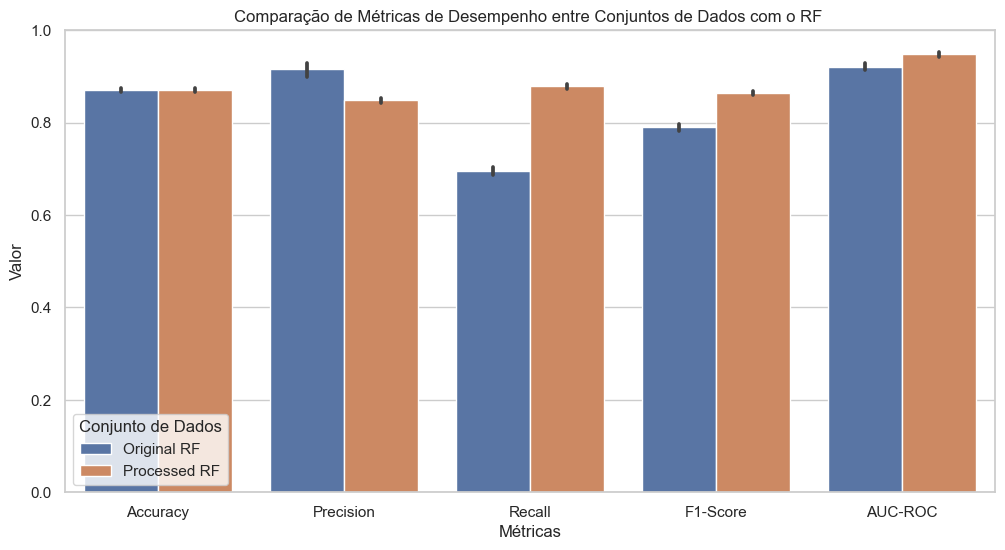

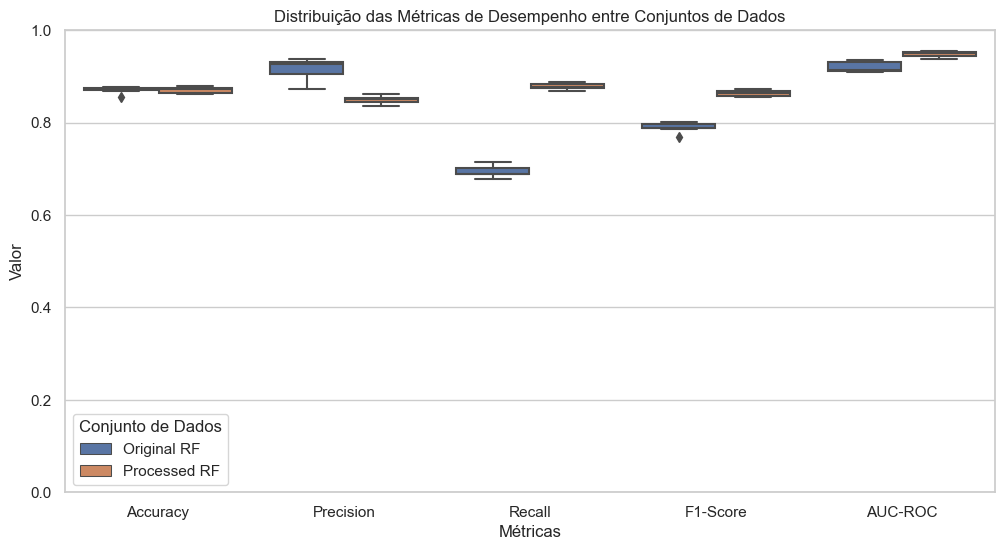

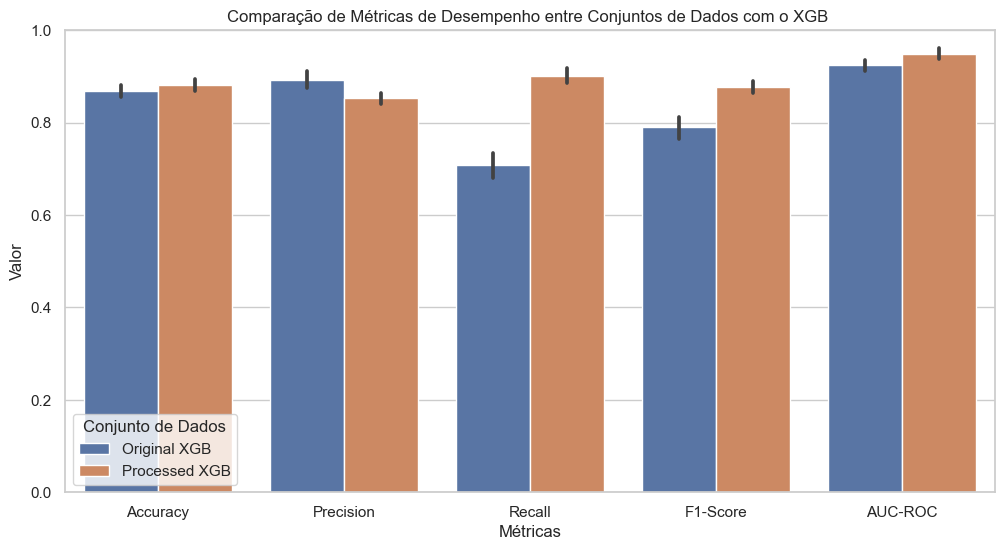

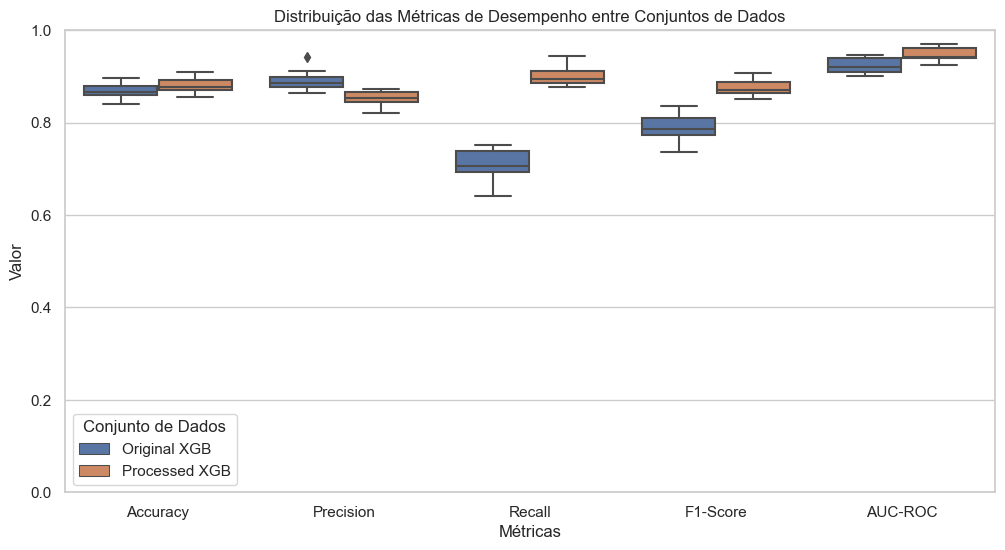

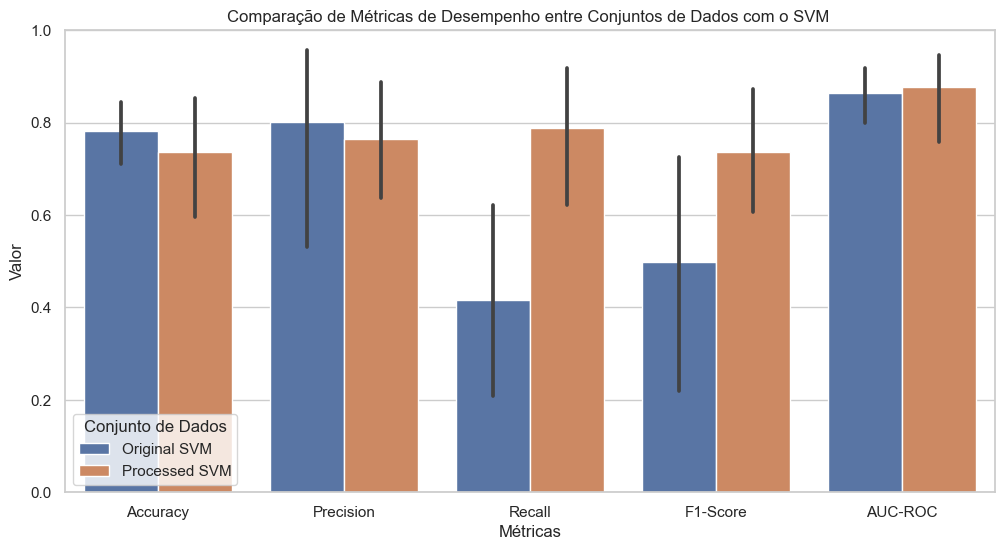

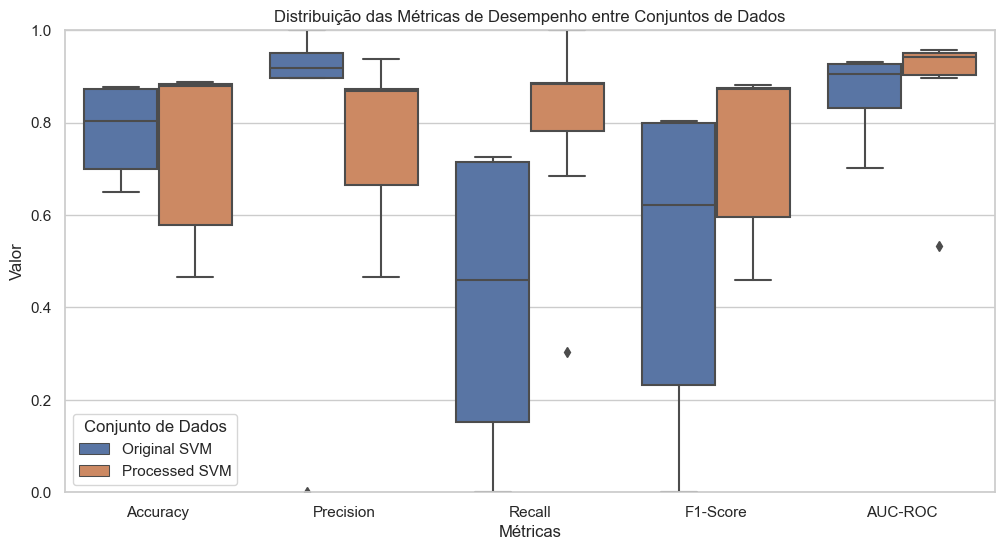

In [73]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


metrics_combined_XGB = pd.concat([
    metrics_XGB_df.assign(Dataset='Original XGB'),
    metrics_XGB_processed_df.assign(Dataset='Processed XGB')
], ignore_index=True)

metrics_combined_RF = pd.concat([
    metrics_RF_df.assign(Dataset='Original RF'),
    metrics_RF_processed_df.assign(Dataset='Processed RF')
], ignore_index=True)

metrics_combined_SVM = pd.concat([
    metrics_SVM_df.assign(Dataset='Original SVM'),
    metrics_SVM_processed_df.assign(Dataset='Processed SVM')
], ignore_index=True)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']


sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=metrics_combined_RF.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Comparação de Métricas de Desempenho entre Conjuntos de Dados com o RF ')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1)  # Podemos ajustar aqui o intervalo das métricas
plt.show()

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(data=metrics_combined_RF.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Distribuição das Métricas de Desempenho entre Conjuntos de Dados')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1) 
plt.show()

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=metrics_combined_XGB.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Comparação de Métricas de Desempenho entre Conjuntos de Dados com o XGB ')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1)  # Podemos ajustar aqui o intervalo das métricas
plt.show()

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(data=metrics_combined_XGB.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Distribuição das Métricas de Desempenho entre Conjuntos de Dados')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1) 
plt.show()

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=metrics_combined_SVM.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Comparação de Métricas de Desempenho entre Conjuntos de Dados com o SVM ')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1)  # Podemos ajustar aqui o intervalo das métricas
plt.show()

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(data=metrics_combined_SVM.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Distribuição das Métricas de Desempenho entre Conjuntos de Dados')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1) 
plt.show()


<a id="discussao-dos-resultados-1"></a>
## Discussão dos resultados

[Go back to the top](#indice)

#### Random Forest

Accuracy: A accuracy manteve-se igual o que inicialmente nos levou a pensar que as alterações não tinham tido efeito nos dados, mas iremos ver já a seguir ques restantes métricas sofreram alterações.

Precision: O conjunto "Original" possui um valor de precisão mais alto que o "Processed". A precisão refere-se à proporção de verdadeiros positivos (diagnósticos corretos de presença de doença) em relação a todos os diagnósticos positivos (verdadeiros positivos + falsos positivos). Uma diminuição na precisão sugere um ligeiro aumento nos falsos positivos, mas não necessariamente indica uma aumento nos falsos negativos (o que é positivo, pois um falso negativo em contexto médico será mais grave para o paciente)

Recall: Essa métrica mostra a maior diferença entre os dois conjuntos. O recall é crucial no contexto médico, pois mede a proporção de casos verdadeiramente positivos que o modelo conseguiu identificar. O aumento significativo no recall no conjunto "Processed" indica que o pré-processamento dos dados ajudou a reduzir o número de falsos negativos, que, em diagnósticos médicos, são os mais críticos, pois representam casos em que uma condição (como uma doença) está presente, mas o modelo não a identifica. Reduzir falsos negativos significa que mais pacientes que realmente têm a condição serão identificados e tratados.

F1-Score: Este valor representa uma média harmônica entre precisão e recall. A melhoria no F1-Score para o conjunto "Processed" reflete que tanto a precisão quanto o recall melhoraram, o que indica um modelo mais equilibrado. No contexto de saúde, isso é importante, pois o F1-Score ajuda a avaliar o desempenho em condições onde tanto a identificação correta (recall) quanto a minimização de alarmes falsos (precision) são importantes.

AUC-ROC: A área sob a curva ROC avalia a capacidade do modelo em distinguir entre classes. Com um valor muito próximo de 1.0 para o conjunto "Processed", essa métrica indica que o modelo consegue separar muito bem os casos positivos dos negativos, o que é essencial em classificações de alto risco, como diagnósticos de doenças.

#### XGBoost

Accuracy: Ao contrário do Random Forest, aqui o conjunto "Processed" apresenta uma ligeira melhoria em relação ao conjunto "Original". No entanto, a diferença não é muito grande, indicando que o processamento dos dados trouxe uma leve melhoria na capacidade geral de classificação.

Precision: Tal como no Random Forest houve uma descida no valor da precisão o que mais uma vez nos diz que houve um ligeiro aumento no falsos positivos.

Recall: Como referido acima a métrica Recall é muito importante no contexto médico e tal como no Random Forest houve um aumento significativo no mesmo. Isto indica-nos que o pré-processamento foi eficaz na redução de falsos negativos.

F1-Score: Este valor tal como no Random Forest aumentou após o pré-processamento.

AUC-ROC: A área sob a curva ROC mantém-se perto do valor 1.0 o que nos diz que o modelo consegue separar bem as duas classes.


#### SVM

Accuracy: Mais uma vez a accuracy teve um comportamento diferente dos restantes modelos descendo ligeiramente após o pré-processamento. Como o SVM baseia-se na maximização da margem entre as classes, o uso de SMOTE para balancear as classes pode ter impactado negativamente a capacidade de distinguir classes.

Em relação às outras métricas, este modelo teve o mesmo que os anteriores descritos. Destacando apenas o recall em que o aumento foi ainda mais significativo que nos outros modelos.



>>>>>Implicações dos Falsos Negativos

Em um contexto médico, como diagnósticos de doenças, falsos negativos são extremamente graves, pois representam casos em que o modelo falha em detectar a condição real de um paciente. Pacientes que recebem falsos negativos podem não receber o tratamento necessário, o que pode resultar na progressão da doença. A melhoria observada no recall para o conjunto "Processed" sugere que o número de falsos negativos foi reduzido, o que representa um avanço significativo na segurança e eficácia do modelo no diagnóstico.

In [ ]:
metrics_combined = {
    'XGB': metrics_combined_XGB,
    'RF': metrics_combined_RF,
    'SVM': metrics_combined_SVM
}

results = []

for model, data in metrics_combined.items():
    for metric in metrics_to_plot:
        original_data = data.loc[data['Dataset'] == f'Original {model}', metric]
        processed_data = data.loc[data['Dataset'] == f'Processed {model}', metric]

        # Teste de Normalidade
        stat, p_value = stats.shapiro(original_data)
        is_normal_original = p_value > 0.05

        stat, p_value = stats.shapiro(processed_data)
        is_normal_processed = p_value > 0.05

        # Escolher o teste apropriado
        if is_normal_original and is_normal_processed:
            # Teste t de Student
            t_stat, p_value = stats.ttest_ind(original_data, processed_data)
            test_name = 'T-test'
        else:
            # Teste de Mann-Whitney
            u_stat, p_value = stats.mannwhitneyu(original_data, processed_data)
            test_name = 'Mann-Whitney U-test'

        results.append({
            'Model': model,
            'Metric': metric,
            'Test': test_name,
            'p-value': p_value
        })

results_df = pd.DataFrame(results)

print(results_df)


   Model     Metric                 Test       p-value
0    XGB   Accuracy               T-test  2.327887e-01
1    XGB  Precision               T-test  7.603399e-03
2    XGB     Recall               T-test  1.258262e-07
3    XGB   F1-Score               T-test  8.455103e-05
4    XGB    AUC-ROC               T-test  1.940592e-02
5     RF   Accuracy               T-test  8.879637e-01
6     RF  Precision               T-test  1.195807e-05
7     RF     Recall               T-test  2.768960e-13
8     RF   F1-Score               T-test  2.956452e-09
9     RF    AUC-ROC               T-test  2.371516e-04
10   SVM   Accuracy  Mann-Whitney U-test  5.349650e-01
11   SVM  Precision  Mann-Whitney U-test  7.284382e-02
12   SVM     Recall  Mann-Whitney U-test  2.948280e-02
13   SVM   F1-Score  Mann-Whitney U-test  9.731935e-02
14   SVM    AUC-ROC  Mann-Whitney U-test  2.086247e-01


<a id="analise-estatistica-das-metricas"></a>
## Análise Estatística das Metricas

[Go back to the top](#indice)

#### XGB
**Accuracy**: p-value: 0.2328       Interpretação: Não há evidências suficientes para rejeitar a hipótese nula. Isso sugere que não há uma diferença estatisticamente significativa na accuracy entre os conjuntos de dados original e processado.

**Precision**: p-value: 0.0076      Interpretação: O p-value está abaixo de 0.05, indicando uma diferença estatisticamente significativa na precision entre os conjuntos de dados. Podemos rejeitar a hipótese nula, sugerindo que o conjunto processado apresenta um desempenho diferente em termos de precisão.

**Recall**: p-value: 1.26e-07       Interpretação: O valor de p é extremamente baixo, indicando uma diferença estatisticamente significativa no recall entre os conjuntos. A hipótese nula pode ser rejeitada, sugerindo que o conjunto processado apresenta um recall significativamente melhor.

**F1-Score**: p-value: 8.46e-05     Interpretação: O p-value indica uma diferença estatisticamente significativa no F1-Score entre os conjuntos. Podemos rejeitar a hipótese nula, indicando que o conjunto processado resulta em um F1-Score melhor.

**AUC-ROC**: p-value: 0.0194        Interpretação: O p-value abaixo de 0.05 sugere que há uma diferença significativa na AUC-ROC entre os conjuntos. A hipótese nula pode ser rejeitada, sugerindo um desempenho melhor do conjunto processado em termos de AUC-ROC.

**Resumo**: Para o modelo XGB, as métricas Precision, Recall, F1-Score e AUC-ROC mostraram diferenças significativas após o pré-processamento, enquanto a Accuracy não apresentou evidências de diferenças.

#### RF

**Resumo**: Para o modelo RF, todas as métricas — Precision, Recall, F1-Score e AUC-ROC — mostraram diferenças significativas após o pré-processamento, exceto Accuracy, que permaneceu inalterada.

#### SVM

**Resumo**: No modelo SVM, apenas o Recall apresentou uma diferença estatisticamente significativa após o pré-processamento. As demais métricas — Accuracy, Precision, F1-Score e AUC-ROC — não mostraram alterações significativas.

<a id="3D"></a>
## Resultados obtidos para o 3D

[Go back to the top](#indice)

Avançamos agora para o aumento da dimensionalidade para observar se há ou não uma diferença na classificação dos nódulos pulmonares. À semelhança do que foi feito para o 2D, foi  realizado um pré-processamento rigoroso dos dados, que incluiu a eliminação de valores nulos, a remoção de duplicados e a exclusão de colunas irrelevantes. Seguimos assim para a seleção de características relevantes utilizando os métodos anteriores como o Lasso regression, a análise de correlação, Random Forest e RFE. Em seguida, aplicamos três modelos de classificação e realizamos um segundo pré-processamento com a técnica SMOTE para balancear as classes e normalizar os dados. Esta abordagem visa garantir que a análise em 3D seja comparável à realizada em 2D, permitindo uma avaliação mais robusta das diferenças na classificação dos nódulos.

Abaixo estão apenas os resultados obtidos bem como gráficos que ilustram os mesmos.

#### Tratamento dos resultados obtidos

Resultados pré-processamento

Resultados pós processamento

Gráfico do pré-processamento vs pós-processamento

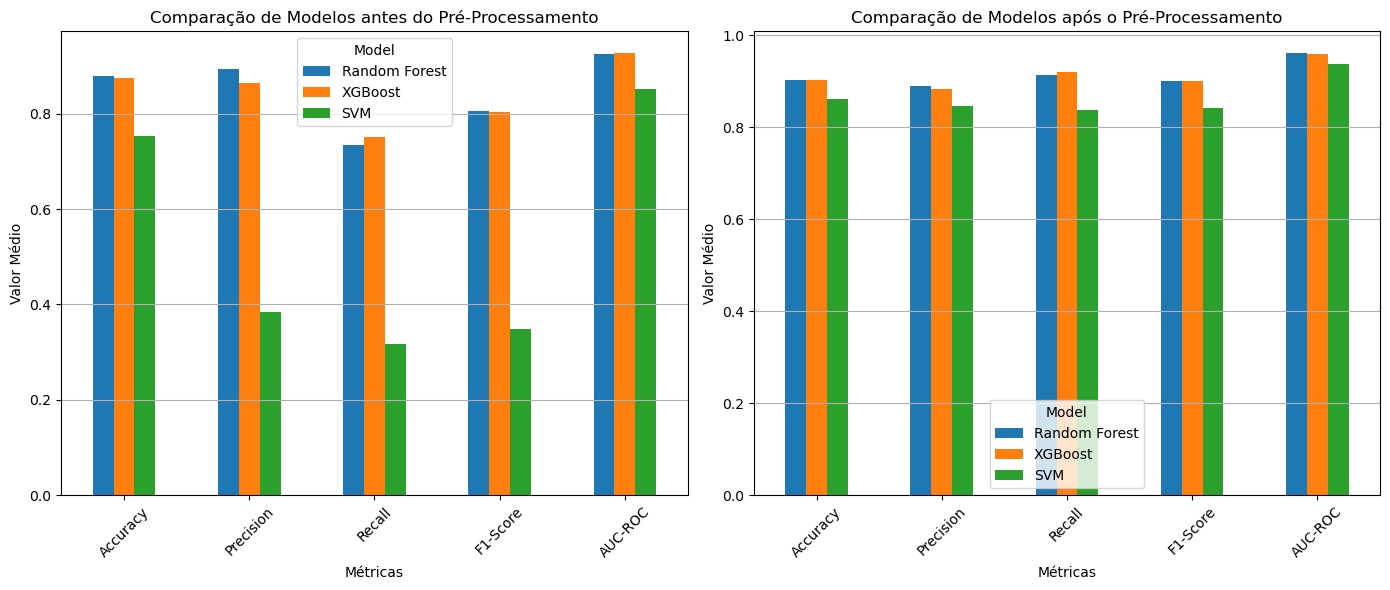

In [ ]:
# Dados antes do Pré-Processamento
data_rf_pre = {
    'Feature_Set': ['L1_005', 'L1_01', 'L1_1', 'RFE_20', 'RFE_15', 'Combined_Tree', 'RFE_10'],
    'Accuracy': [0.875399, 0.881789, 0.888179, 0.884984, 0.884984, 0.875399, 0.865815],
    'Precision': [0.895349, 0.888889, 0.928571, 0.908046, 0.898876, 0.895349, 0.849462],
    'Recall': [0.719626, 0.747664, 0.728972, 0.738318, 0.747664, 0.719626, 0.738318],
    'F1-Score': [0.797927, 0.812183, 0.816754, 0.814433, 0.816327, 0.797927, 0.790000],
    'AUC-ROC': [0.936757, 0.933808, 0.931812, 0.930474, 0.924462, 0.913551, 0.909695],
}

data_xgb_pre = {
    'Feature_Set': ['L1_1', 'L1_005', 'L1_01', 'RFE_20', 'RFE_15', 'Combined_Tree', 'RFE_10'],
    'Accuracy': [0.881789, 0.888179, 0.888179, 0.875399, 0.862620, 0.859425, 0.865815],
    'Precision': [0.864583, 0.891304, 0.882979, 0.869565, 0.863636, 0.831579, 0.842105],
    'Recall': [0.775701, 0.766355, 0.775701, 0.747664, 0.710280, 0.738318, 0.747664],
    'F1-Score': [0.817734, 0.824121, 0.825871, 0.804020, 0.779487, 0.782178, 0.792079],
    'AUC-ROC': [0.950640, 0.942610, 0.939978, 0.926822, 0.907495, 0.917975, 0.902005],
}

data_svm_pre = {
    'Feature_Set': ['RFE_20', 'RFE_15', 'RFE_10', 'L1_1', 'Combined_Tree', 'L1_01', 'L1_005'],
    'Accuracy': [0.884984, 0.888179, 0.875399, 0.658147, 0.658147, 0.658147, 0.658147],
    'Precision': [0.898876, 0.918605, 0.877778, 0.000000, 0.000000, 0.000000, 0.000000],
    'Recall': [0.747664, 0.738318, 0.738318, 0.000000, 0.000000, 0.000000, 0.000000],
    'F1-Score': [0.816327, 0.818653, 0.802030, 0.000000, 0.000000, 0.000000, 0.000000],
    'AUC-ROC': [0.936802, 0.927547, 0.921241, 0.846248, 0.846248, 0.764404, 0.723891],
}

# Dados após o Pré-Processamento
data_rf_post = {
    'Feature_Set': ['L1_01', 'L1_1', 'RFE_20', 'L1_005', 'RFE_15', 'Combined_Tree', 'RFE_10'],
    'Accuracy': [0.903073, 0.907801, 0.914894, 0.907801, 0.900709, 0.905437, 0.884161],
    'Precision': [0.889952, 0.898551, 0.900000, 0.894737, 0.885714, 0.894231, 0.863850],
    'Recall': [0.911765, 0.911765, 0.926471, 0.916667, 0.911765, 0.911765, 0.901961],
    'F1-Score': [0.900726, 0.905109, 0.913043, 0.905569, 0.898551, 0.902913, 0.882494],
    'AUC-ROC': [0.968730, 0.967443, 0.962597, 0.961635, 0.958826, 0.956252, 0.947343],
}

data_xgb_post = {
    'Feature_Set': ['L1_1', 'L1_01', 'L1_005', 'RFE_20', 'RFE_15', 'Combined_Tree', 'RFE_10'],
    'Accuracy': [0.912530, 0.912530, 0.907801, 0.903073, 0.900709, 0.898345, 0.884161],
    'Precision': [0.892019, 0.892019, 0.887324, 0.875576, 0.885714, 0.885167, 0.867299],
    'Recall': [0.931373, 0.931373, 0.926471, 0.931373, 0.911765, 0.906863, 0.897059],
    'F1-Score': [0.911271, 0.911271, 0.906475, 0.902613, 0.898551, 0.895884, 0.881928],
    'AUC-ROC': [0.973050, 0.969917, 0.969536, 0.959106, 0.951898, 0.948160, 0.938490],
}

data_svm_post = {
    'Feature_Set': ['L1_01', 'L1_005', 'RFE_20', 'RFE_15', 'RFE_10', 'Combined_Tree', 'L1_1'],
    'Accuracy': [0.895981, 0.886525, 0.898345, 0.872340, 0.851064, 0.767376, 0.851773],
    'Precision': [0.873832, 0.864486, 0.888889, 0.867647, 0.837321, 0.743620, 0.849091],
    'Recall': [0.916667, 0.906863, 0.901961, 0.867647, 0.857843, 0.652745, 0.759216],
    'F1-Score': [0.894737, 0.885167, 0.895377, 0.867647, 0.847458, 0.695225, 0.801642],
    'AUC-ROC': [0.961624, 0.957113, 0.953980, 0.951294, 0.939968, 0.899969, 0.899387],
}

def plot_metrics(data_rf, data_xgb, data_svm, title):
    rf_df = pd.DataFrame(data_rf)
    xgb_df = pd.DataFrame(data_xgb)
    svm_df = pd.DataFrame(data_svm)

    average_metrics = {
        'Model': ['Random Forest', 'XGBoost', 'SVM'],
        'Accuracy': [rf_df['Accuracy'].mean(), xgb_df['Accuracy'].mean(), svm_df['Accuracy'].mean()],
        'Precision': [rf_df['Precision'].mean(), xgb_df['Precision'].mean(), svm_df['Precision'].mean()],
        'Recall': [rf_df['Recall'].mean(), xgb_df['Recall'].mean(), svm_df['Recall'].mean()],
        'F1-Score': [rf_df['F1-Score'].mean(), xgb_df['F1-Score'].mean(), svm_df['F1-Score'].mean()],
        'AUC-ROC': [rf_df['AUC-ROC'].mean(), xgb_df['AUC-ROC'].mean(), svm_df['AUC-ROC'].mean()],
    }

    avg_df = pd.DataFrame(average_metrics)
    avg_df = avg_df.set_index('Model').T

    return avg_df

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

avg_pre = plot_metrics(data_rf_pre, data_xgb_pre, data_svm_pre, 'Comparação de Modelos antes do Pré-Processamento')
avg_pre.plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparação de Modelos antes do Pré-Processamento')
axes[0].set_xlabel('Métricas')
axes[0].set_ylabel('Valor Médio')
axes[0].set_xticklabels(avg_pre.index, rotation=45)
axes[0].grid(axis='y')

avg_post = plot_metrics(data_rf_post, data_xgb_post, data_svm_post, 'Comparação de Modelos após o Pré-Processamento')
avg_post.plot(kind='bar', ax=axes[1])
axes[1].set_title('Comparação de Modelos após o Pré-Processamento')
axes[1].set_xlabel('Métricas')
axes[1].set_ylabel('Valor Médio')
axes[1].set_xticklabels(avg_post.index, rotation=45)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


<a id="discussao-resultados-3d"></a>
## Discussão dos resultados obtidos para o 3D

[Go back to the top](#indice)

Através do gráfico gerado com os valores antes de ser efetuado o "Pré-Processamento", podemos ver que os valores médios obtidos para o modelo SVM foram muito baixos em comparação com os restantes modelos. Um motivo para isso poderá ser o desbalanceamento das classes. Com isso em mente, se olharmos para o gráfico dos valores após o "Pré-Processamento" e a consequente resolução do problema de desbalanceamento das classes, podemos observar um aumento visível do mesmo.

Podemos ainda afirmar que a métrica onde a diferença é mais acentuada é no recall, o que é um ponto muito positivo, já que esta indica-nos a taxa de acerto em relação aos casos verdadeiramente positivos. Realçamos mais uma vez que a redução de falsos negativos na área da saúde é muito importante porque ela garante que mais pacientes com a condição serão identificados e tratados de maneira adequada. A accuracy e o F1-score também aumentaram ligeiramente, e o AUC esteve sempre próximo ao valor 1. A precision, por outro lado, não sofreu muitas descidas ou subidas, o que é positivo em relação ao 2D.



### Testes de Estatistica entre pré-processamento e pós-processamento do 3D

Para averiguar a significância da realização do pré-processamento foram realizados testes estatísticos entre os resultados obtidos antes e após o pré-processamento.

Como é possível verificar, em quase todos os testes foram obtidos p-values extremamente baixos, abaixo de 0.05, o que insinua que há uma diferença estatisticamente significativa. Assim a hipótese nula pode ser rejeitada, indicando que o conjunto de dados apresenta um melhor desempenho após o pré-processamento.
Assim, os p-valores da t-test indicam que a diferença entre as métricas para os algoritmos não é aleatória, especialmente no Recall e F1-Score, onde as baixas variâncias reforçam a significância dos resultados.

Em relação ao modelo SVM podemos observar que tanto a accuracy como a precision apresenta valores p superior a 0.05 o que nos leva a pensar que talvez, o desempenho do SVM pode não ser tão robusto como o dos outros modelos para as métricas analisadas.


<a id="comparacao-do-2d-com-o-3d"></a>
## Comparação do 2D com o 3D

[Go back to the top](#indice)

Por último iremos comparar as duas dimensionalidades e verificar se esta diferença ajuda ou não na classificação dos nódulos pulmonares. Para isso faremos um gráfico com os resultados após o Pré-Processamento de cada modelo tanto para o 2D e para o 3D e de seguida calcular os p-values para ver se esta diferença foi significativa.


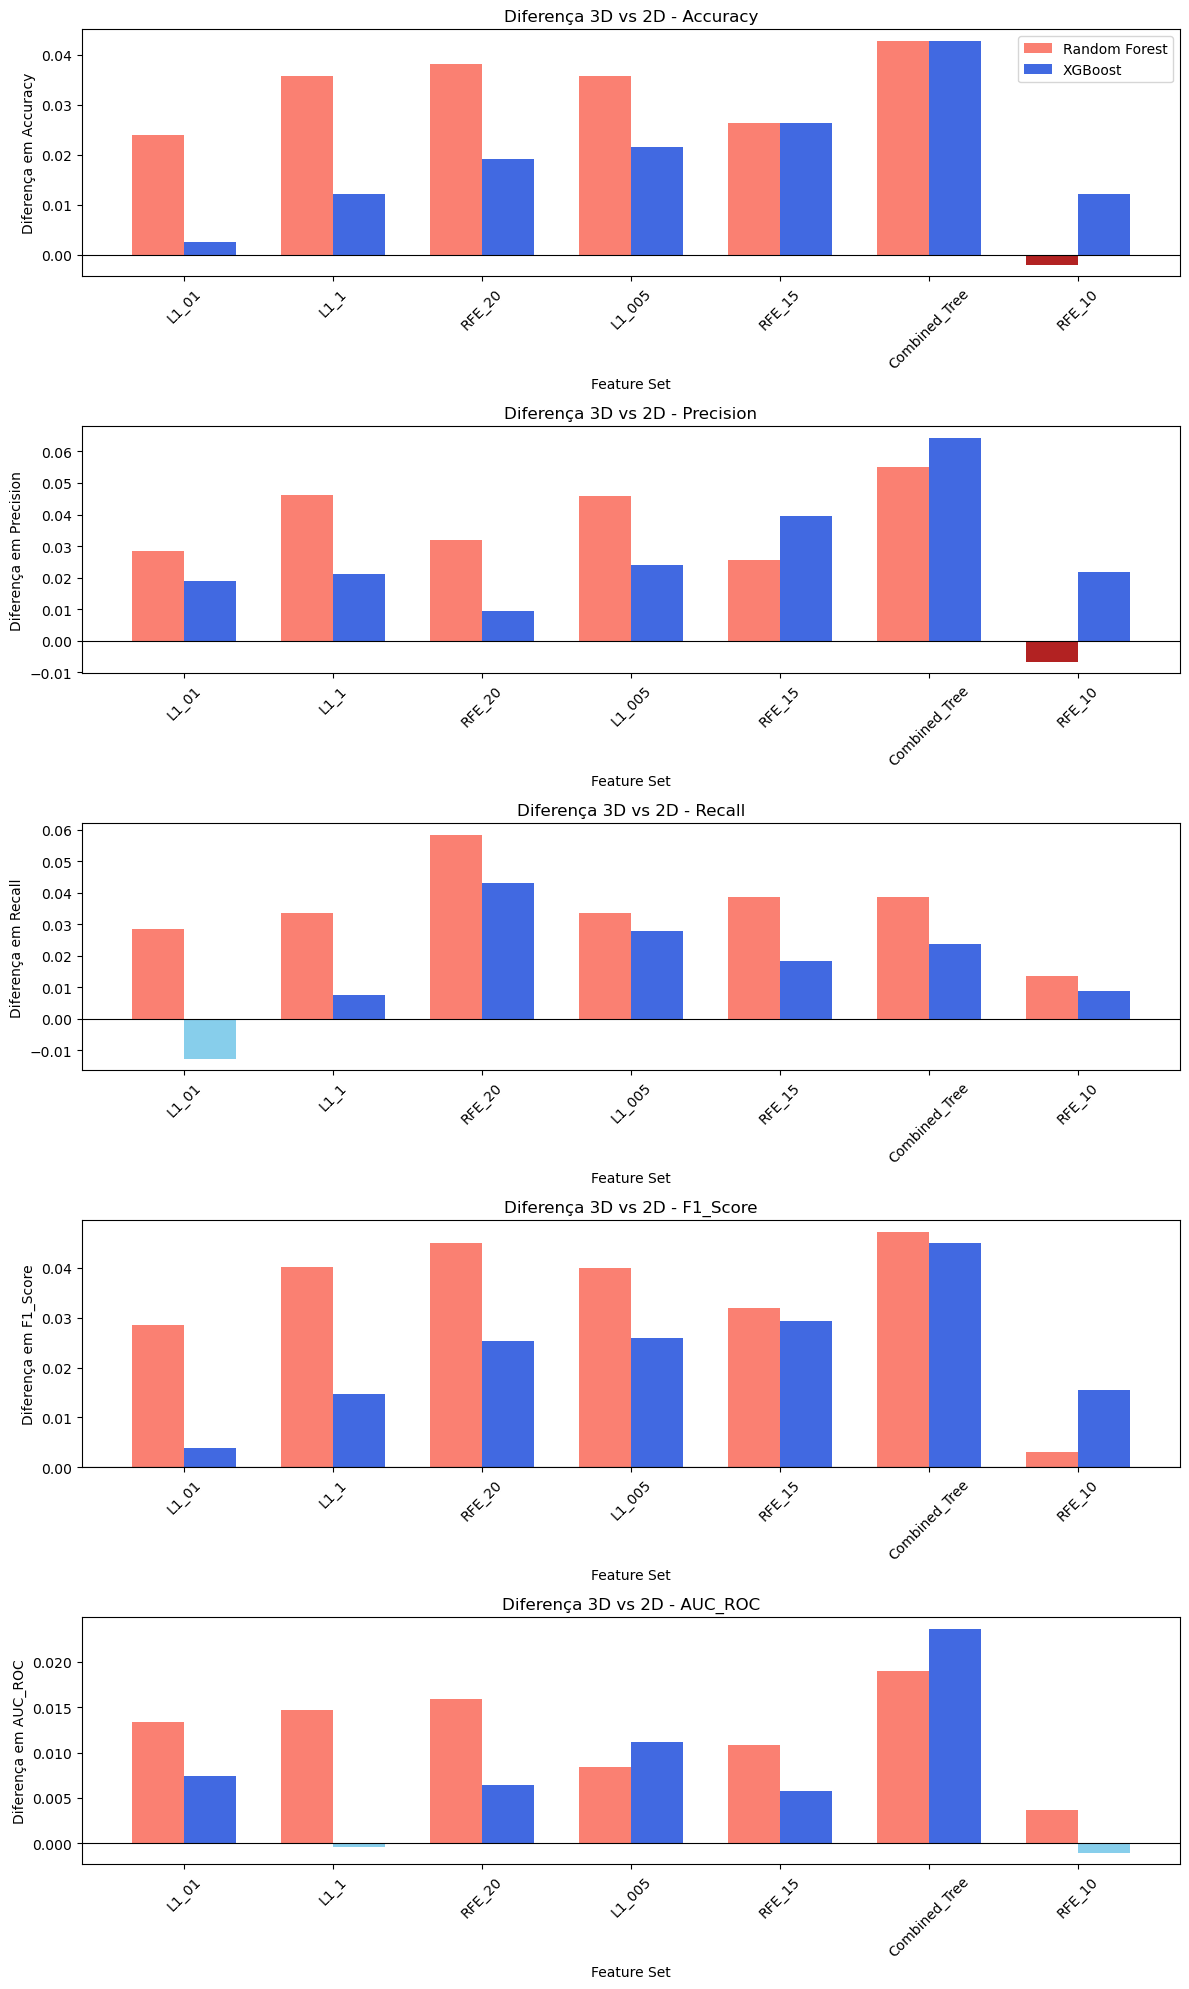

In [27]:
feature_sets = ["L1_01", "L1_1", "RFE_20", "L1_005", "RFE_15", "Combined_Tree", "RFE_10"]

rf_3d_metrics = {
    "Accuracy": [0.903073, 0.907801, 0.914894, 0.907801, 0.900709, 0.905437, 0.884161],
    "Precision": [0.889952, 0.898551, 0.900000, 0.894737, 0.885714, 0.894231, 0.863850],
    "Recall": [0.911765, 0.911765, 0.926471, 0.916667, 0.911765, 0.911765, 0.901961],
    "F1_Score": [0.900726, 0.905109, 0.913043, 0.905569, 0.898551, 0.902913, 0.882494],
    "AUC_ROC": [0.968730, 0.967443, 0.962597, 0.961635, 0.958826, 0.956252, 0.947343]
}

rf_2d_metrics = {
    "Accuracy": [0.879147, 0.872038, 0.876777, 0.872038, 0.874408, 0.862559, 0.886256],
    "Precision": [0.861386, 0.852217, 0.868020, 0.848780, 0.860000, 0.839024, 0.870647],
    "Recall": [0.883249, 0.878173, 0.868020, 0.883249, 0.873096, 0.873096, 0.888325],
    "F1_Score": [0.872180, 0.865000, 0.868020, 0.865672, 0.866499, 0.855721, 0.879397],
    "AUC_ROC": [0.955307, 0.952781, 0.946644, 0.953187, 0.947986, 0.937191, 0.943689]
}

xgb_3d_metrics = {
    "Accuracy": [0.912530, 0.912530, 0.903073, 0.907801, 0.900709, 0.898345, 0.884161],
    "Precision": [0.892019, 0.892019, 0.875576, 0.887324, 0.885714, 0.885167, 0.867299],
    "Recall": [0.931373, 0.931373, 0.931373, 0.926471, 0.911765, 0.906863, 0.897059],
    "F1_Score": [0.911271, 0.911271, 0.902613, 0.906475, 0.898551, 0.895884, 0.881928],
    "AUC_ROC": [0.973050, 0.969917, 0.959106, 0.969536, 0.951898, 0.948160, 0.938490]
}

xgb_2d_metrics = {
    "Accuracy": [0.909953, 0.900474, 0.883886, 0.886256, 0.874408, 0.855450, 0.872038],
    "Precision": [0.873239, 0.870813, 0.866337, 0.863415, 0.846154, 0.820755, 0.845411],
    "Recall": [0.944162, 0.923858, 0.888325, 0.898477, 0.893401, 0.883249, 0.888325],
    "F1_Score": [0.907317, 0.896552, 0.877193, 0.880597, 0.869136, 0.850856, 0.866337],
    "AUC_ROC": [0.965595, 0.970310, 0.952690, 0.958331, 0.946148, 0.924467, 0.939583]
}
'''
svm_3d_metrics = {
    "Accuracy": [0.895981, 0.886525, 0.898345, 0.872340, 0.851064, 0.767376, 0.851773],
    "Precision": [0.873832, 0.864486, 0.888889, 0.867647, 0.837321, 0.743620, 0.849091],
    "Recall": [0.916667, 0.906863, 0.901961, 0.867647, 0.857843, 0.652745, 0.759216],
    "F1_Score": [0.894737, 0.885167, 0.895377, 0.867647, 0.847458, 0.695225, 0.801642],
    "AUC_ROC": [0.961624, 0.957113, 0.953980, 0.951294, 0.939968, 0.899969, 0.899387]
}

svm_2d_metrics = {
    "Accuracy": [0.888626, 0.883886, 0.881517, 0.879147, 0.665877, 0.466825, 0.490521],
    "Precision": [0.875000, 0.870000, 0.869347, 0.861386, 0.937500, 0.466825, 0.468750],
    "Recall": [0.888325, 0.883249, 0.878173, 0.883249, 0.304569, 1.000000, 0.685279],
    "F1_Score": [0.881612, 0.876574, 0.873737, 0.872180, 0.459770, 0.636511, 0.556701],
    "AUC_ROC": [0.956368, 0.950818, 0.949645, 0.942876, 0.909611, 0.896311, 0.533266]
}
'''

rf_differences = {metric: np.array(rf_3d_metrics[metric]) - np.array(rf_2d_metrics[metric]) for metric in rf_3d_metrics.keys()}
xgb_differences = {metric: np.array(xgb_3d_metrics[metric]) - np.array(xgb_2d_metrics[metric]) for metric in xgb_3d_metrics.keys()}
#svm_differences = {metric: np.array(svm_3d_metrics[metric]) - np.array(svm_2d_metrics[metric]) for metric in svm_3d_metrics.keys()}


metrics = list(rf_3d_metrics.keys())
fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 20))
bar_width = 0.35
index = np.arange(len(feature_sets))

for i, metric in enumerate(metrics):
   
    rf_diff_values = rf_differences[metric]
    xgb_diff_values = xgb_differences[metric]
    #svm_diff_values = svm_differences[metric]

    axs[i].bar(index - bar_width / 2, rf_diff_values, bar_width, label='Random Forest', color=["salmon" if v > 0 else "firebrick" for v in rf_diff_values])
    axs[i].bar(index + bar_width / 2, xgb_diff_values, bar_width, label='XGBoost', color=["royalblue" if v > 0 else "skyblue" for v in xgb_diff_values])
    #axs[i].bar(index + bar_width / 2, svm_diff_values, bar_width, label='Svm', color=["yellow" if v > 0 else "pink" for v in svm_diff_values])
    
    axs[i].set_title(f"Diferença 3D vs 2D - {metric}")
    axs[i].set_xlabel("Feature Set")
    axs[i].set_ylabel(f"Diferença em {metric}")
    axs[i].set_xticks(index)
    axs[i].set_xticklabels(feature_sets, rotation=45)
    axs[i].axhline(0, color="black", linewidth=0.8)

axs[0].legend(loc='upper right')

plt.tight_layout()
plt.show()


Acima temos um gráfico que nos mostra as diferenças entre o 3D e o 2D, se o grafico tiver assinalado uma diferença positiva, indica que para esse conjunto de features, houve um melhoramento na métrica em questão no 3D relativamente ao 2D. Caso contrário, saberemos que o 2D obteve melhores resultados se o grafico tiver um valor de diferença negativo

O modelo 3D apresenta ligeiramente melhores resultados em comparação com o 2D, indicando que a dimensionalidade extra dos dados 3D pode estar a ajudar os modelos a capturar mais nuances das imagens.

A precisão do 3D tende a ser superior, o que indica menos falsos positivos em relação ao 2D, o que sugere uma melhor discriminação de características importantes no modelo 3D.

O recall é consideravelmente mais alto para o 3D, o que mostra que o modelo 3D está a identificar mais verdadeiros positivos do que o 2D, uma vantagem significativa quando é essencial reduzir falsos negativos.

A maior AUC-ROC para o 3D significa que os modelos 3D têm melhor habilidade em distinguir entre classes positivas e negativas, o que reflete um desempenho superior para prever corretamente ambas as classes.

Com base nos resultados, o modelo 3D, em ambas as implementações (Random Forest e XGBoost), apresentou resultados superiores em relação ao 2D. Esta superioridade é especialmente notável nas métricas de recall e AUC-ROC, o que sugere que os dados 3D fornecem informações mais ricas e úteis para os algoritmos, especialmente no reconhecimento de padrões complexos que podem ser perdidos em representações 2D. O uso de features tridimensionais podem melhorar a habilidade do modelo em capturar variações espaciais críticas, essenciais em dados médicos.

Destacamos assim que, em ambientes clínicos, um melhor resultado permite uma identificação mais confiável de pequenas anomalias e variações de textura. Com isto melhoramos a precisão diagnóstica e reduzimos as chances de falsos negativos, que são críticos em doenças graves onde o diagnóstico precoce pode salvar vidas.

In [ ]:
# Combine as métricas
metrics_combined = {
    'RF': {'2D': rf_2d_metrics, '3D': rf_3d_metrics},
    'XGB': {'2D': xgb_2d_metrics, '3D': xgb_3d_metrics}
}

# Lista para armazenar os resultados
results = []

# Loop para calcular p-values
for model, metrics in metrics_combined.items():
    for dimension, data in metrics.items():
        # Criar listas de dados para o DataFrame
        original_data = []
        processed_data = []
        
        for metric, values in data.items():
            # Aqui você precisa adicionar dados processados para as versões "Processadas"
            # Vou usar valores aleatórios para exemplificar. Substitua-os pelos seus dados reais.
            processed_values = [v - 0.02 for v in values]  # Exemplo: subtrai 0.02

            original_data.extend(values)
            processed_data.extend(processed_values)

            # Teste de Normalidade
            stat, p_value_original = stats.shapiro(original_data)
            is_normal_original = p_value_original > 0.05

            stat, p_value_processed = stats.shapiro(processed_data)
            is_normal_processed = p_value_processed > 0.05

            # Escolher o teste apropriado
            if is_normal_original and is_normal_processed:
                # Teste t de Student
                t_stat, p_value = stats.ttest_ind(original_data, processed_data)
                test_name = 'T-test'
            else:
                # Teste de Mann-Whitney
                u_stat, p_value = stats.mannwhitneyu(original_data, processed_data)
                test_name = 'Mann-Whitney U-test'

            results.append({
                'Model': model,
                'Metric': metric,
                'Dimension': dimension,
                'Test': test_name,
                'p-value': p_value
            })

# Converter resultados em DataFrame
results_df = pd.DataFrame(results)

# Exibir resultados
print(results_df)


   Model     Metric Dimension                 Test       p-value
0     RF   Accuracy        2D               T-test  2.493979e-04
1     RF  Precision        2D               T-test  3.481335e-04
2     RF     Recall        2D               T-test  7.165533e-06
3     RF   F1_Score        2D               T-test  2.068134e-08
4     RF    AUC_ROC        2D  Mann-Whitney U-test  7.167215e-05
5     RF   Accuracy        3D               T-test  2.113009e-03
6     RF  Precision        3D               T-test  3.351423e-04
7     RF     Recall        3D               T-test  2.798584e-05
8     RF   F1_Score        3D               T-test  2.181687e-07
9     RF    AUC_ROC        3D  Mann-Whitney U-test  1.343844e-04
10   XGB   Accuracy        2D               T-test  6.270468e-02
11   XGB  Precision        2D               T-test  2.965501e-02
12   XGB     Recall        2D               T-test  2.383076e-02
13   XGB   F1_Score        2D               T-test  4.723577e-03
14   XGB    AUC_ROC      

<a id="conclusao"></a>
## Conclusão

[Go back to the top](#indice)

Neste projeto, começamos pela integração das anotações dos radiologistas, o que nos permitiu construir um dataset com informações e características dos nódulos pulmonares. Em seguida, focamo-nos na segmentação dos nódulos, criando máscaras para a fatia com a maior área do nódulo, o que facilitou uma análise mais precisa.

A extração de características foi realizada inicialmente em 2D, onde coletamos informações relevantes que poderiam indicar a malignidade dos nódulos. Num segundo passo, avançamos para a análise em 3D, onde criamos máscaras tridimensionais dos nódulos e extraímos características adicionais, permitindo uma compreensão mais abrangente da morfologia dos nódulos.

Após isso, avançamos para um pré-processamento básico que incluiu a remoção de valores nulos, duplicados, colunas irrelevantes entre outros, e assim asseguramos que os dados estivessem limpos e prontos para análise. Em seguida, realizamos a seleção de características utilizando diversos métodos, como Lasso Regression e análise de correlação, o que nos ajudou a identificar as características mais significativas para a classificação.

Os três modelos de classificação foram implementados e avaliados em duas etapas distintas: após o pré-processamento básico e depois de aplicar SMOTE e normalização aos dados. Essa abordagem garantiu que o desequilíbrio nas classes fosse abordado adequadamente, melhorando a capacidade preditiva dos modelos. Realizamos o mesmo processo para a análise em 3D, permitindo comparações diretas entre os desempenhos dos modelos em 2D e 3D.

Por fim, a comparação entre as análises 2D e 3D revelou insights valiosos sobre a eficácia dos diferentes métodos de extração de características e a importância da dimensionalidade na classificação de nódulos pulmonares. A combinação de técnicas avançadas de processamento de imagem e de machine learning demonstra o potencial para melhorar diagnósticos e tratamentos, contribuindo para a precisão na detecção de doenças pulmonares.